<a href="https://colab.research.google.com/github/saziaa/Decoding_Energy_Consumption/blob/main/Capstone_v0_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import seaborn as sns
sns.set(font_scale = 1.0)
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy.stats import probplot
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBRegressor

from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression , Ridge
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


**Loading the Dataset**

In [4]:
# Loading the dataset from the xlsx file into a pandas dataframe
df= pd.read_csv('/content/Melbourne_Wastewater_Treatment.csv')

In [5]:
# Rename the columns
column_names = {
    'avg_outflow': 'Avg_outflow',
    'avg_inflow': 'Avg_inflow',
    'total_grid': 'Energy_consumption',
    'Am': 'Ammonia',
    'BOD': 'BOD',
    'COD': 'COD',
    'TN': 'Total_nitrogen',
    'T': 'Avg_temp',
    'TM': 'Max_temp',
    'Tm': 'Min_temp',
    'SLP': 'Atm_pressure',
    'H': 'Avg_humidity',
    'PP': 'Total_precipitation',
    'VV': 'Avg_visibility',
    'V': 'Avg_wind_speed',
    'VM': 'Max_wind_speed',
    'VG': 'Max_gust_speed',
    'year': 'Year',
    'month': 'Month',
    'day': 'Day'
}

data = df.rename(columns=column_names)
data.head()

Avg_outflow  Avg_inflow  Energy_consumption  Ammonia    BOD     COD  \
0        2.941       2.589              175856     27.0  365.0   730.0   
1        2.936       2.961              181624     25.0  370.0   740.0   
2        2.928       3.225              202016     42.0  418.0   836.0   
3        2.928       3.354              207547     36.0  430.0   850.0   
4        2.917       3.794              202824     46.0  508.0  1016.0   

   Total_nitrogen  Avg_temp  Max_temp  Min_temp  Atm_pressure  Avg_humidity  \
0          60.378      19.3      25.1      12.6           0.0            56   
1          60.026      17.1      23.6      12.3           0.0            63   
2          64.522      16.8      27.2       8.8           0.0            47   
3          63.000      14.6      19.9      11.1           0.0            49   
4          65.590      13.4      19.1       8.0           0.0            65   

   Total_precipitation  Avg_visibility  Avg_wind_speed  Max_wind_speed  \
0                 1.52            10.0            26.9            53.5   
1                 0.00            10.0            14.4            27.8   
2                 0.25            10.0            31.9            61.1   
3                 0.00            10.0            27.0            38.9   
4                 0.00            10.0            20.6            35.2   

   Max_gust_speed  Year  Month  Day  
0            79.5  2014      1    1  
1             0.0  2014      1    2  
2            77.8  2014      1    5  
3            53.5  2014      1    6  
4            53.5  2014      1    7

In [6]:
# Convert to MWh
data['Energy_consumption'] = data['Energy_consumption'] / 1000

# Round the values to a certain number of decimal places
data['Energy_consumption'] = data['Energy_consumption'].round(4)


**Exploratory Data Analysis**

**Data Report**

In [17]:
!pip install sweetviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 29.7 MB/s eta 0:00:00


In [ ]:
import sweetviz as sv

# Load the dataset
df= pd.read_csv('/content/Melbourne_Wastewater_Treatment.csv')
data = df.rename(columns=column_names)

# Generate the profile report
report = sv.analyze(df)

# Display the profile report in the web browser
report.show_html(filepath='profile_report.html')

**Summary of the Dataset**

In [5]:
# summarize each variable
data.describe()

Avg_outflow   Avg_inflow  Energy_consumption      Ammonia          BOD  \
count  1382.000000  1382.000000         1382.000000  1382.000000  1382.000000   
mean      3.930608     4.506338          275.159089    39.222302   382.061708   
std       1.228778     1.439583           44.640534     7.761598    85.996012   
min       0.000004     2.589000          116.638000    13.000000   140.000000   
25%       3.074500     3.643250          246.435750    34.000000   330.000000   
50%       3.701000     4.161500          275.808000    39.000000   360.000000   
75%       4.498750     4.847750          305.703750    44.000000   422.980000   
max       7.920000    18.968000          398.328000    93.000000   850.000000   

               COD  Total_nitrogen     Avg_temp     Max_temp     Min_temp  \
count  1382.000000     1382.000000  1382.000000  1382.000000  1382.000000   
mean    845.960434       62.740752    15.036686    20.530897    10.037337   
std     145.416540        3.571035     5.398491     7.096760     4.656887   
min     360.000000       40.000000     0.000000     0.000000    -2.000000   
25%     751.250000       61.396000    10.800000    15.000000     6.800000   
50%     845.000000       62.957500    14.300000    19.200000     9.600000   
75%     920.000000       64.366000    18.575000    25.200000    13.000000   
max    1700.000000       92.000000    35.500000    43.500000    28.500000   

       Atm_pressure  Avg_humidity  Total_precipitation  Avg_visibility  \
count   1382.000000   1382.000000          1382.000000     1382.000000   
mean       3.675036     63.558611             0.218090        9.101592   
std       61.010416     14.534205             1.306923       16.322905   
min        0.000000      0.000000             0.000000        0.000000   
25%        0.000000     55.000000             0.000000        8.400000   
50%        0.000000     66.000000             0.000000       10.000000   
75%        0.000000     74.000000             0.000000       10.000000   
max     1022.000000     97.000000            18.030000      512.000000   

       Avg_wind_speed  Max_wind_speed  Max_gust_speed         Year  \
count     1382.000000     1382.000000     1382.000000  1382.000000   
mean        19.482706       35.381259       29.184009  2016.258321   
std          7.136868       11.626362       31.366315     1.583491   
min          0.000000        0.000000        0.000000  2014.000000   
25%         14.400000       27.800000        0.000000  2015.000000   
50%         18.100000       33.500000        0.000000  2016.000000   
75%         23.300000       42.400000       57.600000  2018.000000   
max         49.100000       83.500000      107.600000  2019.000000   

             Month          Day  
count  1382.000000  1382.000000  
mean      6.184515    15.584660  
std       3.410588     8.741422  
min       1.000000     1.000000  
25%       3.000000     8.000000  
50%       6.000000    15.000000  
75%       9.000000    23.000000  
max      12.000000    31.000000

(1382, 20)


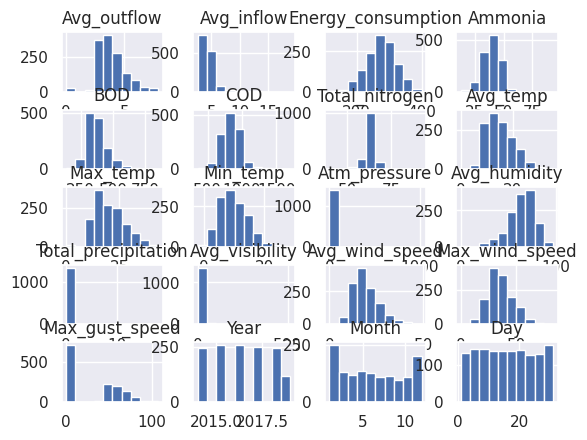

In [13]:
# summarize the shape of the dataset
print(data.shape)
# histograms of the variables
data.hist()
plt.show()

**Scatter plot of each independent variable with dependent variable**

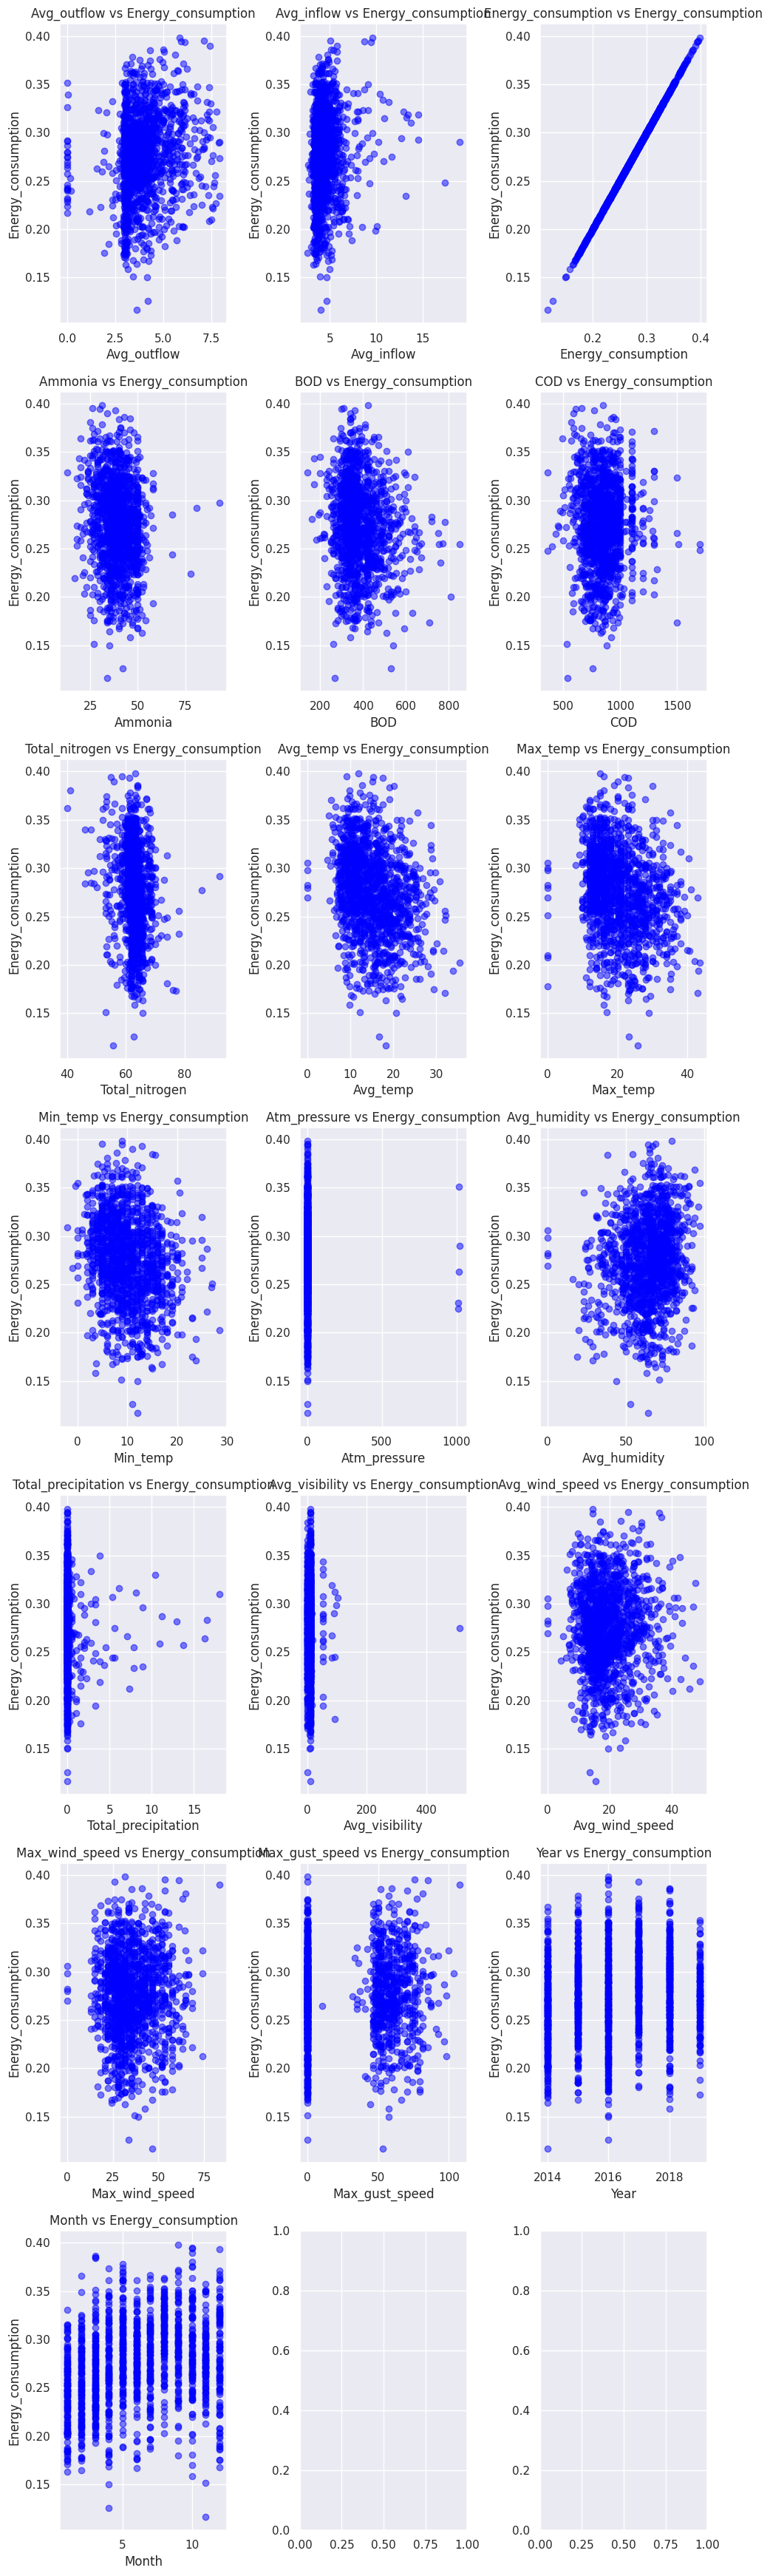

In [ ]:
# Define the number of columns in the subplot grid
num_cols = 3

# Calculate the number of rows needed to accommodate all predictors
num_rows = (len(data.columns) - 1) // num_cols + 1

# Create a subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5*num_rows))

# Flatten the axes array to iterate over it
axes = axes.flatten()

# Iterate over each predictor column
for i, col in enumerate(data.columns[:-1]):
    ax = axes[i]
    ax.plot(data[col], data['Energy_consumption'], marker='o', linestyle='None', color='blue', alpha=0.5)  # Plot predictor vs target
    ax.set_title(f'{col} vs Energy_consumption')
    ax.set_xlabel(col)  # Set x-axis label
    ax.set_ylabel('Energy_consumption')
    ax.grid(True)  # Add gridlines

# Remove any empty subplots if the number of predictors is not a multiple of num_cols
if len(data.columns) % num_cols != 0:
    for ax in axes[len(data.columns):-1]:
        ax.remove()

# Adjust layout to prevent overlap of subplots
plt.tight_layout()



# Show the plot
plt.show()


**Visualization of energy consumption per year**

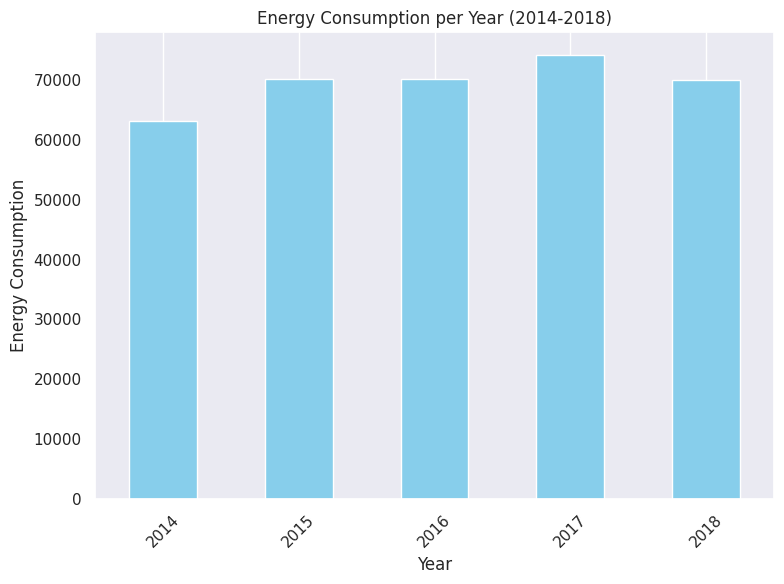

In [ ]:
# Filter data for the years 2014 to 2018
data_2014_to_2018 = data[(data['Year'] >= 2014) & (data['Year'] <= 2018)]

# Group by year and sum the energy consumption for each year
energy_per_year = data_2014_to_2018.groupby('Year')['Energy_consumption'].sum()

# Plotting
plt.figure(figsize=(8, 6))
energy_per_year.plot(kind='bar', color='skyblue')
plt.title('Energy Consumption per Year (2014-2018)')
plt.xlabel('Year')
plt.ylabel('Energy Consumption')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**Visualization of energy consumption per month**

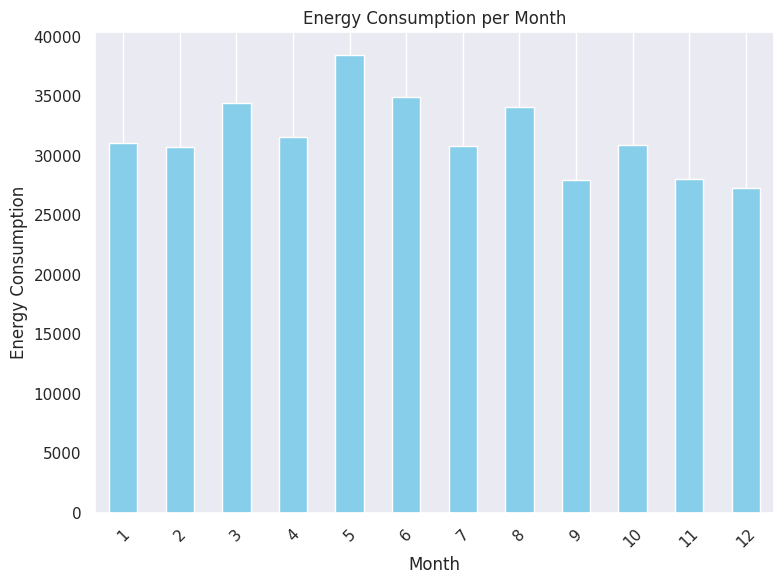

In [ ]:
# Group the data by month and sum the energy consumption for each month
energy_per_month = data.groupby('Month')['Energy_consumption'].sum()

# Plotting
plt.figure(figsize=(8, 6))
energy_per_month.plot(kind='bar', color='skyblue')
plt.title('Energy Consumption per Month')
plt.xlabel('Month')
plt.ylabel('Energy Consumption')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**Data Preprocessing**

**Checking zero values**

In [8]:
zero_values = data.isin([0]).sum()
print("Columns with zero values:")
print(zero_values[zero_values > 0])

Columns with zero values:
Avg_temp                  5
Max_temp                 10
Min_temp                  8
Atm_pressure           1377
Avg_humidity              5
Total_precipitation    1273
Avg_visibility          277
Avg_wind_speed            5
Max_wind_speed            5
Max_gust_speed          716
dtype: int64


**Checking outliers**

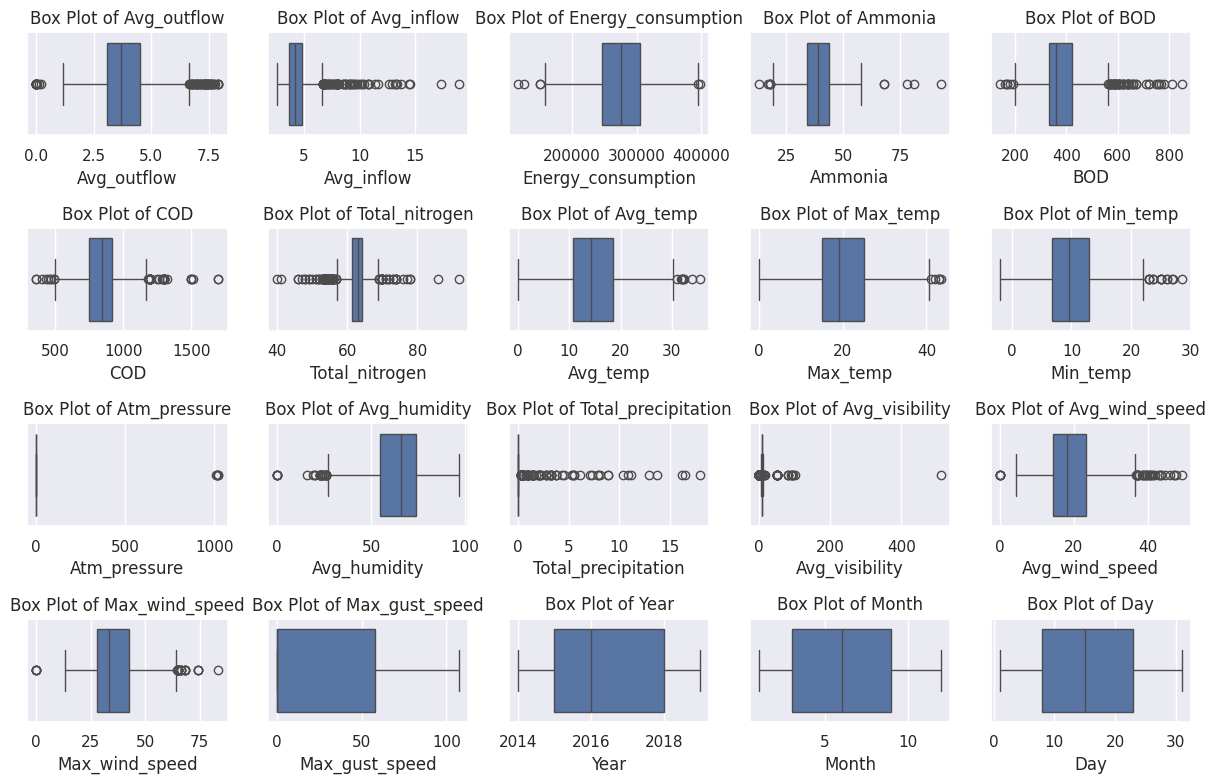

In [ ]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Iterate over each numerical column and create a box plot
for i, col in enumerate(data.select_dtypes(include='number').columns):
    plt.subplot(4,5, i+1)
    sns.boxplot(x=data[col])
    plt.xlabel(col)
    plt.title(f'Box Plot of {col}')

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

**Imputing zero values by KNN**

In [7]:
# Columns for KNN imputation

columns_to_impute_knn = ['Avg_temp', 'Max_temp', 'Atm_pressure',
                         'Avg_humidity', 'Avg_wind_speed', 'Max_wind_speed',
                         'Max_gust_speed']
# Replace zero values with NaN to indicate missing values
data_for_imputation = data.copy()
data_for_imputation[columns_to_impute_knn] = data_for_imputation[columns_to_impute_knn].replace(0, np.nan)

# Initialize KNN imputer
imputer = KNNImputer()

# Impute missing values with KNN for specified columns
data_imputed = data_for_imputation.copy()  # Create a copy of the original dataset
data_imputed[columns_to_impute_knn] = imputer.fit_transform(data_for_imputation[columns_to_impute_knn])

In [8]:
zero_values = data_imputed.isin([0]).sum()
print("Columns with zero values:")
print(zero_values[zero_values > 0])

Columns with zero values:
Min_temp                  8
Total_precipitation    1273
Avg_visibility          277
dtype: int64


**Visualization of KDE plot after imputaion of zero values**

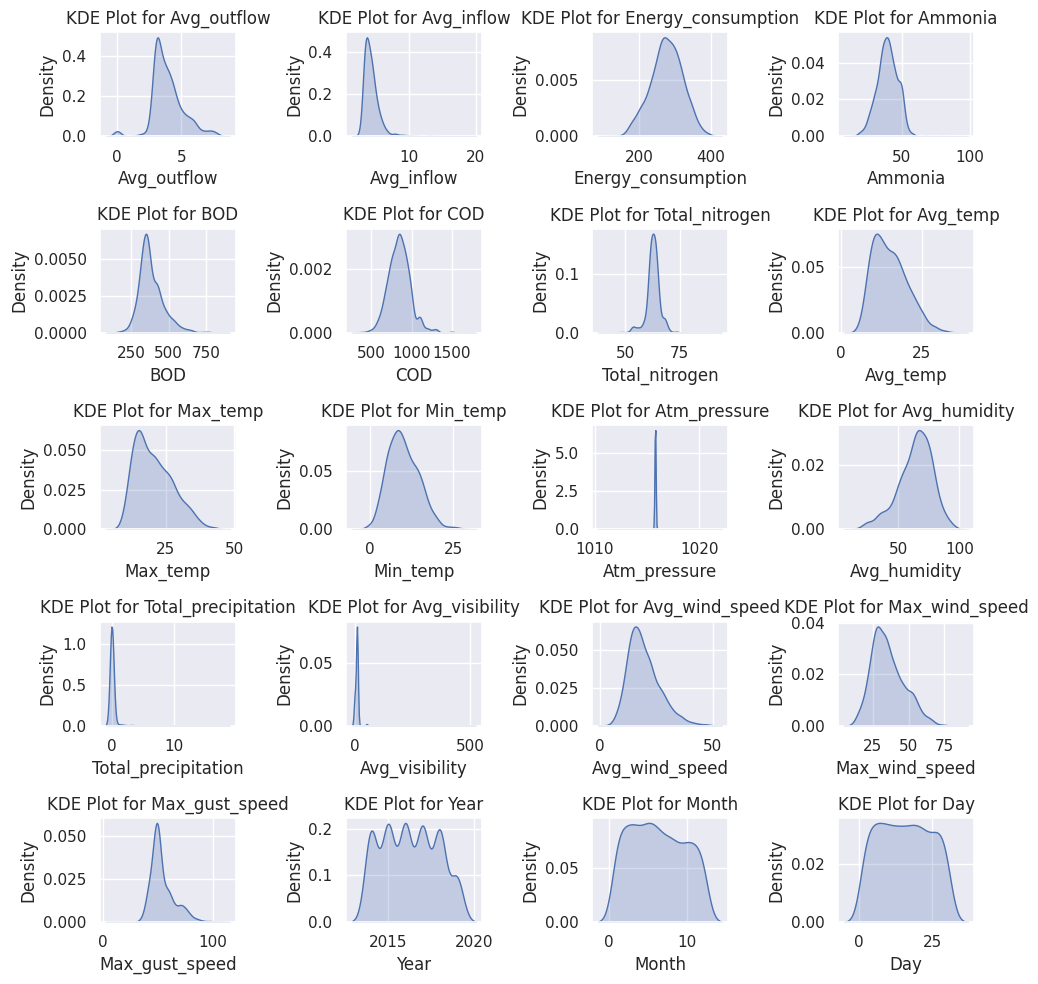

In [17]:
# Define the columns for which you want to create KDD plots
columns_for_kde = ['Avg_outflow', 'Avg_inflow', 'Energy_consumption', 'Ammonia', 'BOD', 'COD',
                   'Total_nitrogen', 'Avg_temp', 'Max_temp', 'Min_temp', 'Atm_pressure',
                   'Avg_humidity', 'Total_precipitation', 'Avg_visibility', 'Avg_wind_speed',
                   'Max_wind_speed', 'Max_gust_speed', 'Year', 'Month', 'Day']

# Set up the figure and axes
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot KDD for each column
for i, col in enumerate(columns_for_kde):
    sns.kdeplot(data=data_imputed[col], ax=axes[i], fill=True)
    axes[i].set_title(f'KDE Plot for {col}')

# Adjust layout
plt.tight_layout()
plt.show()

**Visualizing Correlation Matrix**

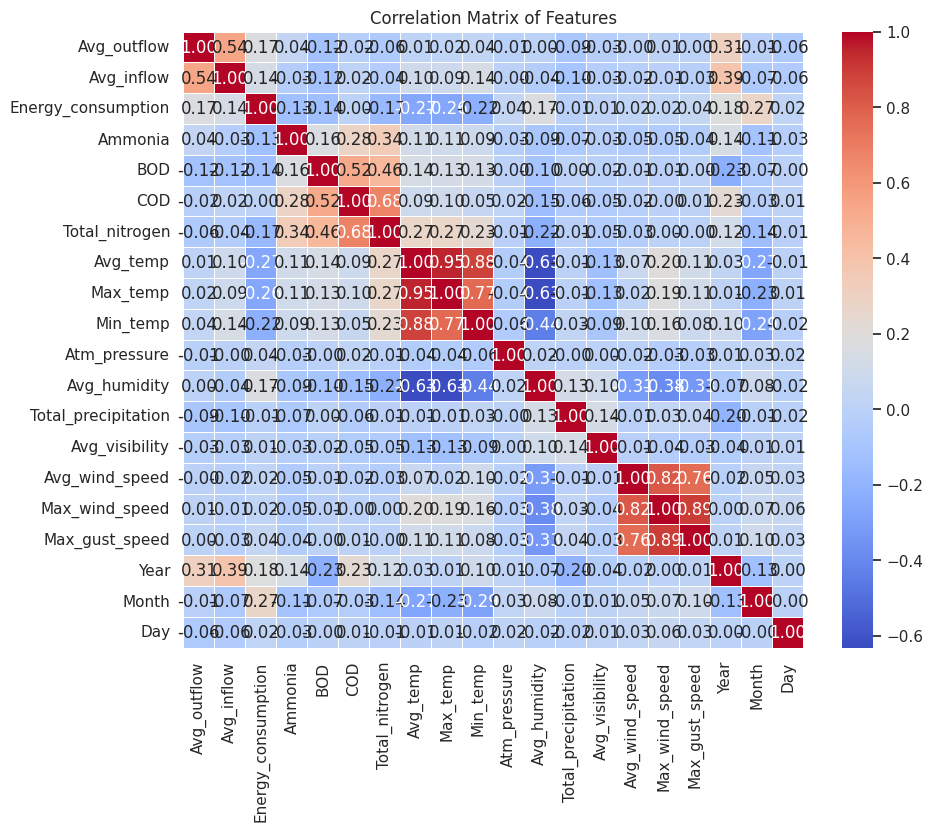

In [ ]:
# Calculate the correlation matrix
correlation_matrix = data_imputed.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Add title and display the plot
plt.title('Correlation Matrix of Features')
plt.show()

From the correlation matrix, we see that


*   The Avg_temp, Max_temp and Min_temp are highly correlated.
*   Another high correlation exists among Avg_wind_speed, Max_wind_speed and Max_gust_speed.

*  COD has moderate correlation (0.52) with BOD as COD is the standard analysis for measuring oxygen consumption during the decomposition of organic and oxidizing of inorganic matter and BOD is the standard method for determining the concentration of oxygen demand required by microorganisms to decompose organic matter.
*  COD has moderate correlation(0.68) with Total_nitrogen as well. COD represents the amount of organic matter (such as pollutants, organic chemicals, and biodegradable substances) in waste water. As organic matter decomposes, it releases nitrogen compounds so when the Chemical Oxygen Demand (COD) increases, it can lead to an increase in total nitrogen levels.


**Splitting into train and test set**

In [9]:
# Define features (X) and target variable (y) for training set
cnt = data_imputed.Year[data_imputed.Year<=2017].count()
X_train = data_imputed.iloc[:cnt].drop(columns=['Energy_consumption'])
y_train = data_imputed.iloc[:cnt]['Energy_consumption']

# Define features (X) and target variable (y) for test set
X_test = data_imputed.iloc[cnt:].drop(columns=['Energy_consumption'])
y_test = data_imputed.iloc[cnt:]['Energy_consumption']

# Print the shapes of the resulting datasets to verify the split
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1016, 19)
X_test shape: (366, 19)
y_train shape: (1016,)
y_test shape: (366,)


**Identifying and removing outliers by Isolation Forest**

In [10]:
# Initialize Isolation Forest for outlier detection
iso = IsolationForest(contamination=0.05,random_state=42)

# Identify outliers in the training dataset
yhat_train = iso.fit_predict(X_train)

# Select rows that are not outliers
mask_train = yhat_train != -1
X_train_cleaned = X_train[mask_train]
y_train_cleaned = y_train[mask_train]

# Print the shape of the training dataset before and after outlier removal
print("Shape of training dataset before outlier removal:", X_train.shape)
print("Shape of training dataset after outlier removal:", X_train_cleaned.shape)

# Initialize and train Linear Regression model
model = LinearRegression()
model.fit(X_train_cleaned, y_train_cleaned)

# Make predictions on the training set
y_pred_train = model.predict(X_train_cleaned)

# Calculate MAE for the training set
mae_train = mean_absolute_error(y_train_cleaned, y_pred_train)
print("MAE on the training set:", mae_train)

# Make predictions on the test set
y_pred_test = model.predict(X_test)

# Calculate MAE for the test set
mae_test = mean_absolute_error(y_test, y_pred_test)
print("MAE on the test set:", mae_test)

Shape of training dataset before outlier removal: (1016, 19)
Shape of training dataset after outlier removal: (965, 19)
MAE on the training set: 30.106260142698382
MAE on the test set: 37.14232061788919


**Applyting Robust Scaling on predictors variables**

In [11]:
from sklearn.preprocessing import RobustScaler

# Initialize RobustScaler
scaler = RobustScaler()

# Fit and transform the scaler on training data
X_train_scaled = scaler.fit_transform(X_train_cleaned)

# Transform the test data using the fitted scaler
X_test_scaled = scaler.transform(X_test)

# Convert scaled array back to DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Print the shapes of the scaled datasets to verify the transformation
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

X_train_scaled shape: (965, 19)
X_test_scaled shape: (366, 19)


**Visualizing KDE before & after RobustScaling**

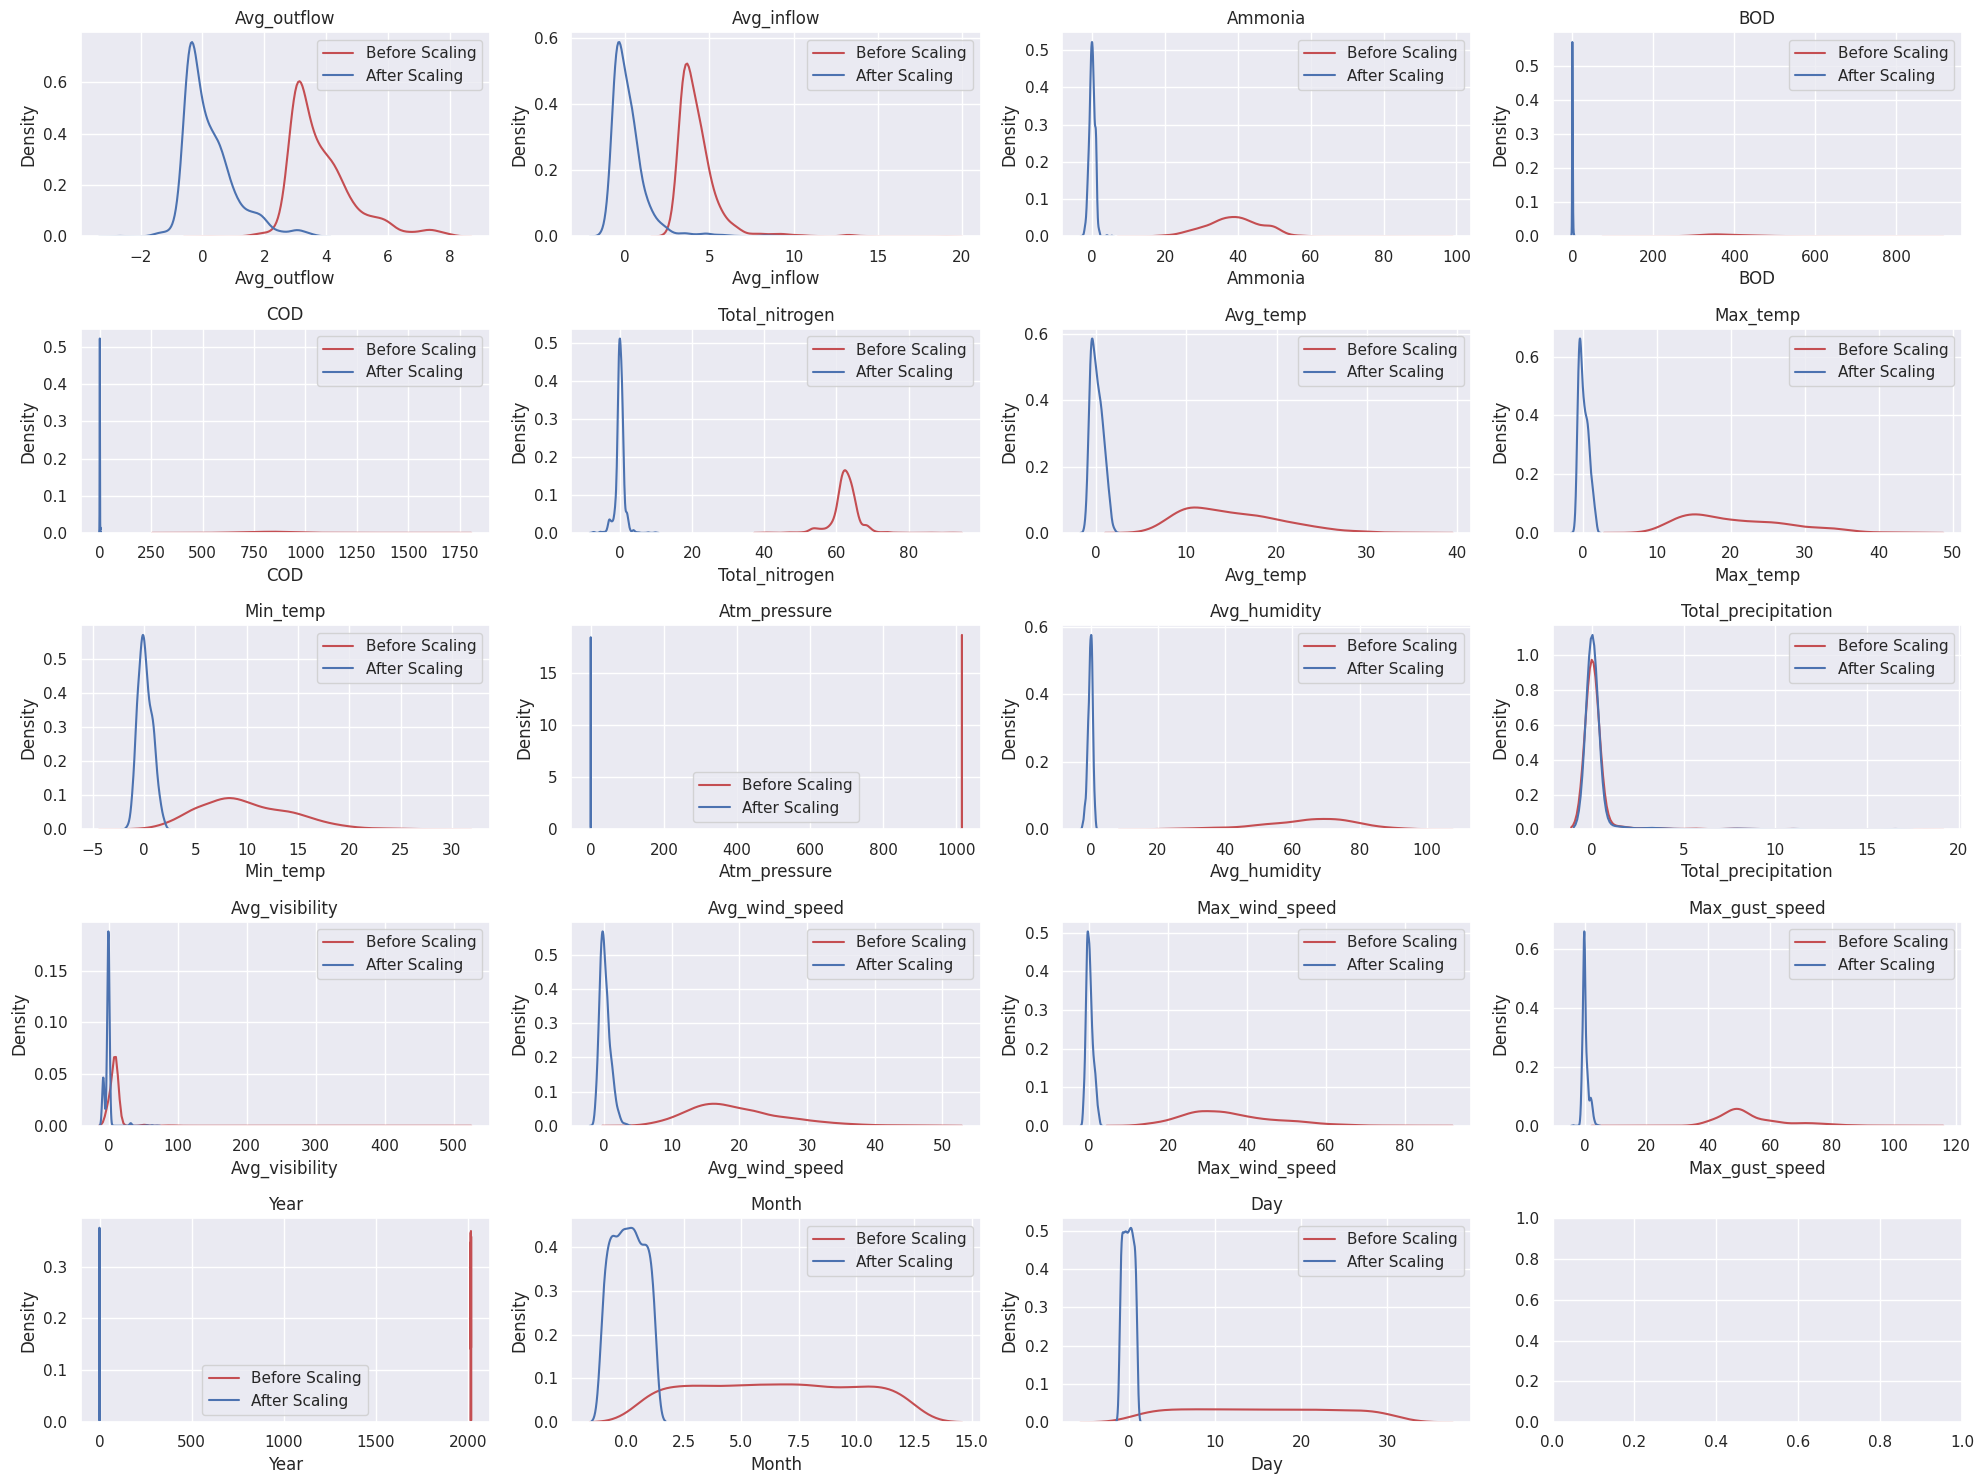

In [16]:
# Define the number of rows and columns for subplots
num_rows = 5
num_cols = 4

# Create subplots with the specified number of rows and columns
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot KDE for each column
for i, column in enumerate(X_train.columns):
    # Plot before scaling
    sns.kdeplot(X_train[column], ax=axes[i], color='r', label='Before Scaling')
    # Plot after scaling
    sns.kdeplot(X_train_scaled_df[column], ax=axes[i], color='b', label='After Scaling')
    # Set title for each subplot
    axes[i].set_title(column)
    # Add legend
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

**KS test to check the distribution of dependent variable**

In [12]:
from scipy.stats import kstest, norm

# Select the column for which you want to perform the KS test (e.g., Energy_consumption)
sample_data = data_imputed['Energy_consumption']

# Perform KS test using a normal distribution as the reference distribution
ks_statistic, p_value = kstest(sample_data, 'norm', args=(sample_data.mean(), sample_data.std()))

# Significance level (alpha)
alpha = 0.05

# Print the test result
print("KS Statistic:", ks_statistic)
print("P-value:", p_value)

# Compare p-value to the significance level
if p_value <= alpha:
    print("Reject the null hypothesis (Sample does not follow the specified distribution).")
else:
    print("Fail to reject the null hypothesis (Sample follows the specified distribution).")

KS Statistic: 0.02077686253199923
P-value: 0.5822741707565813
Fail to reject the null hypothesis (Sample follows the specified distribution).


Based on the results of the Kolmogorov-Smirnov (KS) test, with a KS statistic of 0.0208 and a corresponding p-value of 0.5823, we fail to reject the null hypothesis. This suggests that the sample follows the specified distribution, indicating compatibility with linear regression assumptions.

**F-test to check the overall significance of a regression model**

In [13]:
import statsmodels.api as sm

# Add a constant term to the predictors for the intercept
X_with_intercept = sm.add_constant(X_train_cleaned)

# Fit a linear regression model
model = sm.OLS(y_train_cleaned, X_with_intercept)
results = model.fit()

# Perform F-test
f_test_result = results.f_test("Avg_outflow = Avg_inflow = Ammonia = BOD = COD = Total_nitrogen = Avg_temp = Max_temp = Min_temp = Atm_pressure = Avg_humidity = Total_precipitation = Avg_visibility = Avg_wind_speed = Max_wind_speed = Max_gust_speed = Year = Month = Day = 0")
print("F-test p-value:", f_test_result.pvalue)

F-test p-value: 5.886865269521779e-57


The F-test p-value is extremely small, indicating strong evidence against the null hypothesis. This suggests that at least one of the predictor variables has a non-zero coefficient, meaning that the overall model is significant in explaining the variance in the target variable. At least one of the predictor variables has a significant effect on the target variable.

**t-test to assess the significance of individual coefficients within the model**

In [14]:
# Extract t-statistics and p-values for individual coefficients
t_values = results.tvalues
p_values = results.pvalues

# Print t-statistics and p-values for each coefficient
for i, (coef_name, t_val, p_val) in enumerate(zip(X_train_cleaned.columns, t_values, p_values)):
    print(f"{coef_name}: t-value = {t_val}, p-value = {p_val}")

Avg_outflow: t-value = -1.5472992458050046, p-value = 0.12212590950436748
Avg_inflow: t-value = 1.295558123907235, p-value = 0.19544413452298545
Ammonia: t-value = 0.5655743468865807, p-value = 0.5718174270638516
BOD: t-value = -4.322741961823483, p-value = 1.7044181143224936e-05
COD: t-value = -1.109442048734757, p-value = 0.26752177588141757
Total_nitrogen: t-value = 2.7907592436951587, p-value = 0.005364364177155521
Avg_temp: t-value = -2.4530053604993816, p-value = 0.014346579364832716
Max_temp: t-value = 0.4323790421673383, p-value = 0.6655645944509374
Min_temp: t-value = -1.259286724954096, p-value = 0.2082377380134382
Atm_pressure: t-value = -2.3329055581831235, p-value = 0.019862182628828082
Avg_humidity: t-value = 0.31937443467602095, p-value = 0.7495131807213411
Total_precipitation: t-value = 1.9795536429888871, p-value = 0.04804353089246113
Avg_visibility: t-value = 1.0941072591740317, p-value = 0.2741867377254346
Avg_wind_speed: t-value = -2.18437475340665, p-value = 0.0291

Avg_outflow, Avg_inflow, Ammonia, COD, Max_temp, Min_temp,Avg_humidity,Max_wind_speed,Max_gust_speed,Year: these features are statistically  insignificant and suggests that these features may not be important for the model's predictions.

BOD,Total_nitrogen,Avg_temp,Atm_pressure,Total_precipitation, Avg_wind_speed,Month,Day:these features are statistically significant and suggests that these features are important for the model's predictions.

**Feature Selecetion**

In [19]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 6.3 MB/s eta 0:00:00


In [ ]:
import shap

In [23]:
# Define your XGBoost model
xgb_model = XGBRegressor(random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Initialize the time series cross-validator (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=10)

# Initialize GridSearchCV with time series CV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit GridSearchCV to your training data
grid_search.fit(X_train_scaled, y_train_cleaned)

# Extract the best model
best_model = grid_search.best_estimator_
print(best_model)

# Extract feature importances using SHAP
explainer = shap.Explainer(best_model)
shap_values = explainer.shap_values(X_train_scaled)

# Evaluate the performance of the best model on your test data
test_predictions = best_model.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print("Test RMSE:", test_rmse)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
Test RMSE: 41.272855952662766


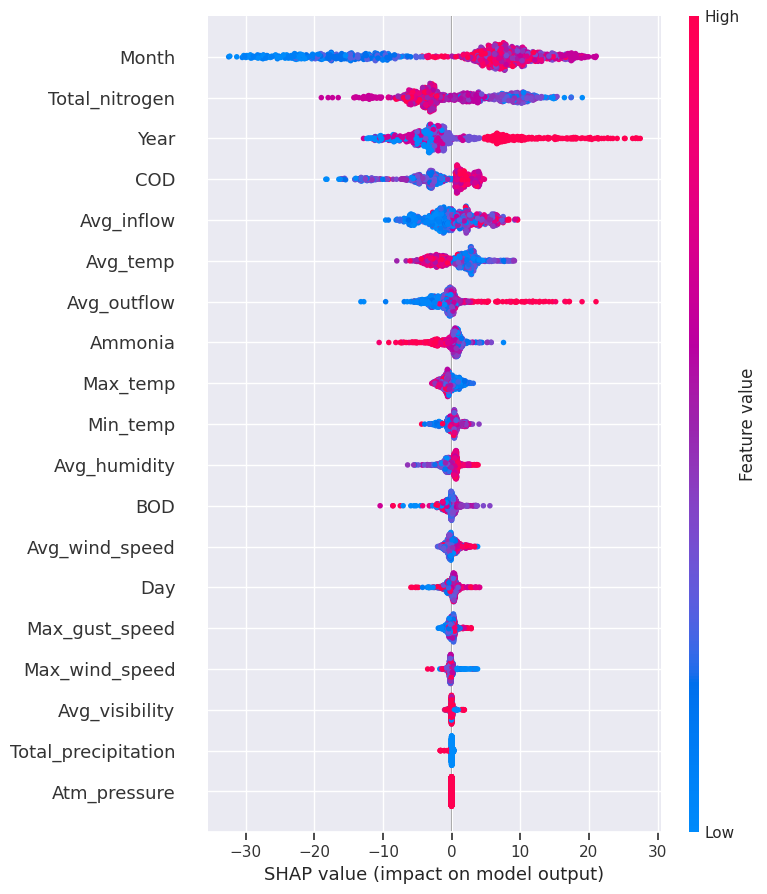

In [21]:
# Plot feature importance with feature names
shap.summary_plot(shap_values, X_train_scaled, feature_names=X_train_scaled_df.columns)

**Applying Naive Baseline**

In [12]:
# Applying Naive Baseline

def baseline_metrics(y_true):
    # Initialize lists to store metric scores for each fold
    rmse_scores, mae_scores, mape_scores, mad_scores = [], [], [], []

    # Initialize time series cross-validator
    tscv = TimeSeriesSplit(n_splits=10)  # Adjust the number of splits as needed

    # Perform time series cross-validation
    for train_index, test_index in tscv.split(y_true):
        # Split the target variable into train and test sets
        y_train_cv, y_test_cv = y_true.iloc[train_index], y_true.iloc[test_index]

        # Calculate the mean of the target variable
        mean_target_value = np.mean(y_train_cv)

        # Generate predictions using the mean target value
        predictions = np.full_like(y_test_cv, fill_value=mean_target_value)

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test_cv, predictions))
        rmse_scores.append(rmse)

        # Calculate MAE
        mae = mean_absolute_error(y_test_cv, predictions)
        mae_scores.append(mae)

        # Calculate MAPE
        mape = np.mean(np.abs((y_test_cv - predictions) / y_test_cv)) * 100
        mape_scores.append(mape)

        # Calculate MAD
        median_value = np.median(y_train_cv)
        absolute_deviations = np.abs(y_test_cv - median_value)
        mad = np.median(absolute_deviations)
        mad_scores.append(mad)

    # Calculate average scores across folds
    avg_rmse = np.mean(rmse_scores)
    avg_mae = np.mean(mae_scores)
    avg_mape = np.mean(mape_scores)
    avg_mad = np.mean(mad_scores)

    return avg_rmse, avg_mae, avg_mape, avg_mad

# Calculate baseline metrics using time series CV
baseline_rmse, baseline_mae, baseline_mape, baseline_mad = baseline_metrics(y_train_cleaned)

print("Baseline RMSE:", baseline_rmse)
print("Baseline MAE:", baseline_mae)
print("Baseline MAPE:", baseline_mape)
print("Baseline MAD:", baseline_mad)

Baseline RMSE: 48.255431650778476
Baseline MAE: 39.17977390863968
Baseline MAPE: 14.231016265583497
Baseline MAD: 34.4987


**Applying Ridge Regression**

In [13]:
# Define selected columns
selected_columns =['Month','Total_nitrogen','Avg_inflow', 'Avg_temp', 'Ammonia','Avg_humidity','BOD','COD','Avg_wind_speed']

# Subset features
X_train_subset = X_train_scaled_df[selected_columns]
X_test_subset = X_test_scaled_df[selected_columns]

# Define time series cross-validation
tscv = TimeSeriesSplit(n_splits=10)

# Instantiate the model
ridge_model = Ridge(alpha=500)

# Initialize lists to store evaluation metrics
train_rmse_scores = []
test_rmse_scores = []
train_mae_scores = []
test_mae_scores = []
train_mape_scores = []
test_mape_scores = []
train_mad_scores = []
test_mad_scores = []

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(tscv.split(X_train_subset), 1):
    X_train_cv, X_test_cv = X_train_subset.iloc[train_index], X_train_subset.iloc[test_index]
    y_train_cv, y_test_cv = y_train_cleaned.iloc[train_index], y_train_cleaned.iloc[test_index]

    # Fit the model
    ridge_model.fit(X_train_cv, y_train_cv)

    # Predict on training and test sets
    y_train_pred = ridge_model.predict(X_train_cv)
    y_test_pred = ridge_model.predict(X_test_cv)

    # Calculate evaluation metrics
    train_rmse = np.sqrt(mean_squared_error(y_train_cv, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test_cv, y_test_pred))
    train_mae = mean_absolute_error(y_train_cv, y_train_pred)
    test_mae = mean_absolute_error(y_test_cv, y_test_pred)
    train_mape = np.mean(np.abs((y_train_cv - y_train_pred) / y_train_cv)) * 100
    test_mape = np.mean(np.abs((y_test_cv - y_test_pred) / y_test_cv)) * 100
    train_mad = median_absolute_error(y_train_cv, y_train_pred)
    test_mad = median_absolute_error(y_test_cv, y_test_pred)

    # Append performance metrics to lists
    train_rmse_scores.append(train_rmse)
    test_rmse_scores.append(test_rmse)
    train_mae_scores.append(train_mae)
    test_mae_scores.append(test_mae)
    train_mape_scores.append(train_mape)
    test_mape_scores.append(test_mape)
    train_mad_scores.append(train_mad)
    test_mad_scores.append(test_mad)

    # Print performance metrics for each fold
    print(f"Fold {fold}:")
    print("Train RMSE:", train_rmse)
    print("Test RMSE:", test_rmse)
    print("Train MAE:", train_mae)
    print("Test MAE:", test_mae)
    print("Train MAPE:", train_mape)
    print("Test MAPE:", test_mape)
    print("Train MAD:", train_mad)
    print("Test MAD:", test_mad)
    print()

# Calculate and print average performance metrics across folds
avg_train_rmse = np.mean(train_rmse_scores)
avg_test_rmse = np.mean(test_rmse_scores)
avg_train_mae = np.mean(train_mae_scores)
avg_test_mae = np.mean(test_mae_scores)
avg_train_mad = np.mean(train_mad_scores)
avg_test_mad = np.mean(test_mad_scores)
avg_train_mape = np.mean(train_mape_scores)
avg_test_mape = np.mean(test_mape_scores)

print("Average Train RMSE:", avg_train_rmse)
print("Average Test RMSE:", avg_test_rmse)
print("Average Train MAE:", avg_train_mae)
print("Average Test MAE:", avg_test_mae)
print("Average Train MAD:", avg_train_mad)
print("Average Test MAD:", avg_test_mad)
print("Average Train MAPE:", avg_train_mape)
print("Average Test MAPE:", avg_test_mape)
print()

Fold 1:
Train RMSE: 33.57605031191676
Test RMSE: 62.53782036049469
Train MAE: 27.346767444252208
Test MAE: 53.38864732278234
Train MAPE: 11.93695569776302
Test MAPE: 17.395774697890946
Train MAD: 23.290882344600476
Test MAD: 54.01880911652364

Fold 2:
Train RMSE: 39.30344088396563
Test RMSE: 33.78474845458992
Train MAE: 32.33833405727007
Test MAE: 23.580095393187747
Train MAPE: 12.943071490949679
Test MAPE: 11.197789569378115
Train MAD: 26.51784922896354
Test MAD: 16.614698811589392

Fold 3:
Train RMSE: 37.42693360128797
Test RMSE: 48.84472590714115
Train MAE: 29.19758183596462
Test MAE: 39.198021104977485
Train MAPE: 12.070136814495697
Test MAPE: 12.894125382458249
Train MAD: 23.27645141645243
Test MAD: 33.95945568248797

Fold 4:
Train RMSE: 39.326515649423
Test RMSE: 38.05751817468896
Train MAE: 31.001222757405802
Test MAE: 31.114433225674023
Train MAPE: 12.419286336661672
Test MAPE: 11.043609281649957
Train MAD: 23.89658461121182
Test MAD: 26.056051631375112

Fold 5:
Train RMSE: 38.

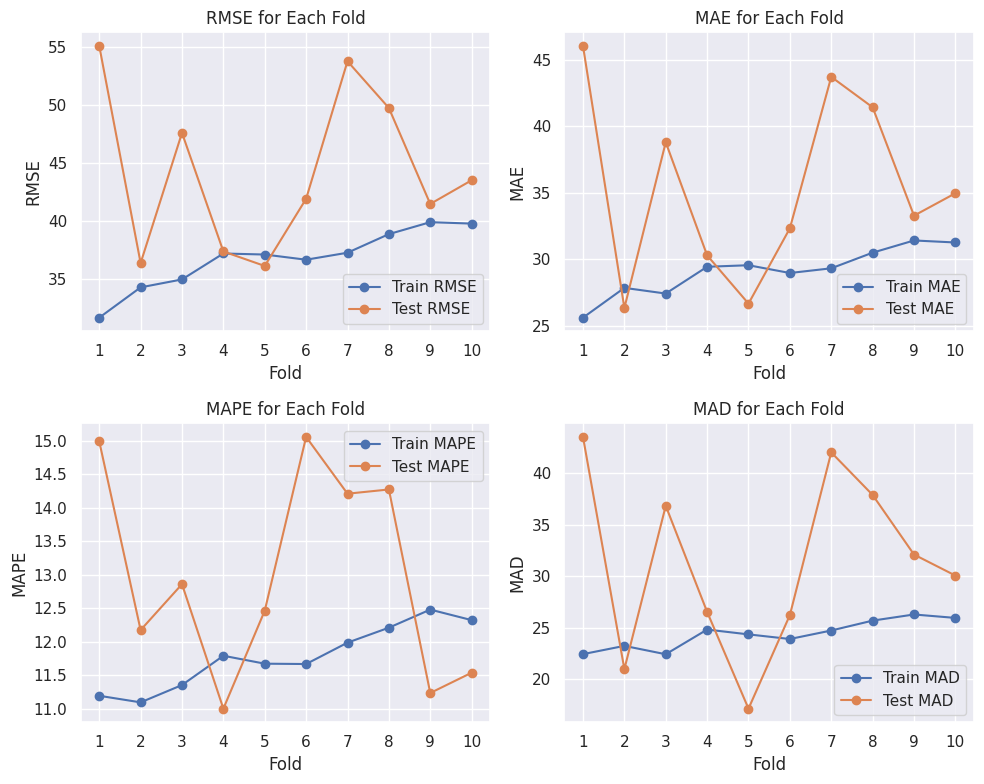

In [ ]:
# Create subplots for each performance metric
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Plotting RMSE for each fold
axes[0, 0].plot(range(1, 11), train_rmse_scores, marker='o', label='Train RMSE')
axes[0, 0].plot(range(1, 11), test_rmse_scores, marker='o', label='Test RMSE')
axes[0, 0].set_title('RMSE for Each Fold')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_xticks(range(1, 11))
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plotting MAE for each fold
axes[0, 1].plot(range(1, 11), train_mae_scores, marker='o', label='Train MAE')
axes[0, 1].plot(range(1, 11), test_mae_scores, marker='o', label='Test MAE')
axes[0, 1].set_title('MAE for Each Fold')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].set_xticks(range(1, 11))
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plotting MAPE for each fold
axes[1, 0].plot(range(1, 11), train_mape_scores, marker='o', label='Train MAPE')
axes[1, 0].plot(range(1, 11), test_mape_scores, marker='o', label='Test MAPE')
axes[1, 0].set_title('MAPE for Each Fold')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('MAPE')
axes[1, 0].set_xticks(range(1, 11))
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plotting MAPE for each fold
axes[1, 1].plot(range(1, 11), train_mad_scores, marker='o', label='Train MAD')
axes[1, 1].plot(range(1, 11), test_mad_scores, marker='o', label='Test MAD')
axes[1, 1].set_title('MAD for Each Fold')
axes[1, 1].set_xlabel('Fold')
axes[1, 1].set_ylabel('MAD')
axes[1, 1].set_xticks(range(1, 11))
axes[1, 1].legend()
axes[1, 1].grid(True)

# Hide the empty subplot
#axes[1, 1].axis('off')

# Adjust layout and display plot
plt.tight_layout()
plt.show()


**Applying SVR**

In [14]:
# Define selected columns
selected_columns = ['Month','Total_nitrogen','Avg_inflow', 'Avg_temp', 'Ammonia','Avg_humidity','BOD','COD','Avg_wind_speed']

# Subset features
X_train_subset = X_train_scaled_df[selected_columns]
X_test_subset = X_test_scaled_df[selected_columns]

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=10)

# Initialize lists to store evaluation metrics for each fold
train_rmse_scores = []
test_rmse_scores = []
train_mae_scores = []
test_mae_scores = []
train_mad_scores = []
test_mad_scores = []
train_mape_scores = []
test_mape_scores = []

# Perform grid search and cross-validation
for fold, (train_index, test_index) in enumerate(tscv.split(X_train_subset), 1):
    X_train_cv, X_test_cv = X_train_subset.iloc[train_index], X_train_subset.iloc[test_index]
    y_train_cv, y_test_cv = y_train_cleaned.iloc[train_index], y_train_cleaned.iloc[test_index]

    # Define SVR model
    svr_model = SVR(kernel='rbf')

    # Define hyperparameters for grid search
    param_grid = {
   # 'kernel': ['linear','rbf', 'poly'],
    'C': [0.06, 0.07, 0.08],
    'epsilon': [0.01, 0.1, 1]
    }

    # Perform grid search
    grid_search = GridSearchCV(svr_model, param_grid, cv=tscv, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_cv, y_train_cv)

    # Get best parameters
    best_params = grid_search.best_params_
    print("Best Parameters:", best_params)

    # Fit the model with best parameters
    best_svr_model = SVR(**best_params)
    best_svr_model.fit(X_train_cv, y_train_cv)

    # Predictions
    y_train_pred = best_svr_model.predict(X_train_cv)
    y_test_pred = best_svr_model.predict(X_test_cv)

    # Evaluate model
    train_rmse = np.sqrt(mean_squared_error(y_train_cv, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test_cv, y_test_pred))
    train_mae = mean_absolute_error(y_train_cv, y_train_pred)
    test_mae = mean_absolute_error(y_test_cv, y_test_pred)
    train_mad = median_absolute_error(y_train_cv, y_train_pred)
    test_mad = median_absolute_error(y_test_cv, y_test_pred)
    train_mape = np.mean(np.abs((y_train_cv - y_train_pred) / y_train_cv)) * 100
    test_mape = np.mean(np.abs((y_test_cv - y_test_pred) / y_test_cv)) * 100

    # Append scores to respective lists
    train_rmse_scores.append(train_rmse)
    test_rmse_scores.append(test_rmse)
    train_mae_scores.append(train_mae)
    test_mae_scores.append(test_mae)
    train_mad_scores.append(train_mad)
    test_mad_scores.append(test_mad)
    train_mape_scores.append(train_mape)
    test_mape_scores.append(test_mape)

    # Print performance metrics for each fold
    print(f"Fold {fold}:")
    print("Train RMSE:", train_rmse)
    print("Test RMSE:", test_rmse)
    print("Train MAE:", train_mae)
    print("Test MAE:", test_mae)
    print("Train MAD:", train_mad)
    print("Test MAD:", test_mad)
    print("Train MAPE:", train_mape)
    print("Test MAPE:", test_mape)
    print()

# Calculate and print average performance metrics across folds
avg_train_rmse = np.mean(train_rmse_scores)
avg_test_rmse = np.mean(test_rmse_scores)
avg_train_mae = np.mean(train_mae_scores)
avg_test_mae = np.mean(test_mae_scores)
avg_train_mad = np.mean(train_mad_scores)
avg_test_mad = np.mean(test_mad_scores)
avg_train_mape = np.mean(train_mape_scores)
avg_test_mape = np.mean(test_mape_scores)

print("Average Train RMSE:", avg_train_rmse)
print("Average Test RMSE:", avg_test_rmse)
print("Average Train MAE:", avg_train_mae)
print("Average Test MAE:", avg_test_mae)
print("Average Train MAD:", avg_train_mad)
print("Average Test MAD:", avg_test_mad)
print("Average Train MAPE:", avg_train_mape)
print("Average Test MAPE:", avg_test_mape)
print()

Best Parameters: {'C': 0.06, 'epsilon': 0.1}
Fold 1:
Train RMSE: 34.61417963418824
Test RMSE: 68.39098620028433
Train MAE: 28.171197878137473
Test MAE: 59.25081018628975
Train MAD: 26.018695002170773
Test MAD: 60.28820939540128
Train MAPE: 12.129990924123659
Test MAPE: 19.348954616347243

Best Parameters: {'C': 0.08, 'epsilon': 0.01}
Fold 2:
Train RMSE: 44.35842095599984
Test RMSE: 34.16992795339593
Train MAE: 36.558881450562616
Test MAE: 24.76636922779122
Train MAD: 33.64013313702279
Test MAD: 17.130612565545505
Train MAPE: 14.575823937524868
Test MAPE: 11.653328600576458

Best Parameters: {'C': 0.08, 'epsilon': 0.1}
Fold 3:
Train RMSE: 41.11274040497168
Test RMSE: 51.129238786756886
Train MAE: 32.45316833335594
Test MAE: 39.944273391473054
Train MAD: 27.22036910117086
Test MAD: 32.578991707834234
Train MAPE: 13.288869381983638
Test MAPE: 13.028296615864077

Best Parameters: {'C': 0.08, 'epsilon': 1}
Fold 4:
Train RMSE: 42.8724363068929
Test RMSE: 39.973730424074986
Train MAE: 33.5793

**Visualization of perfromance metrics for SVR**

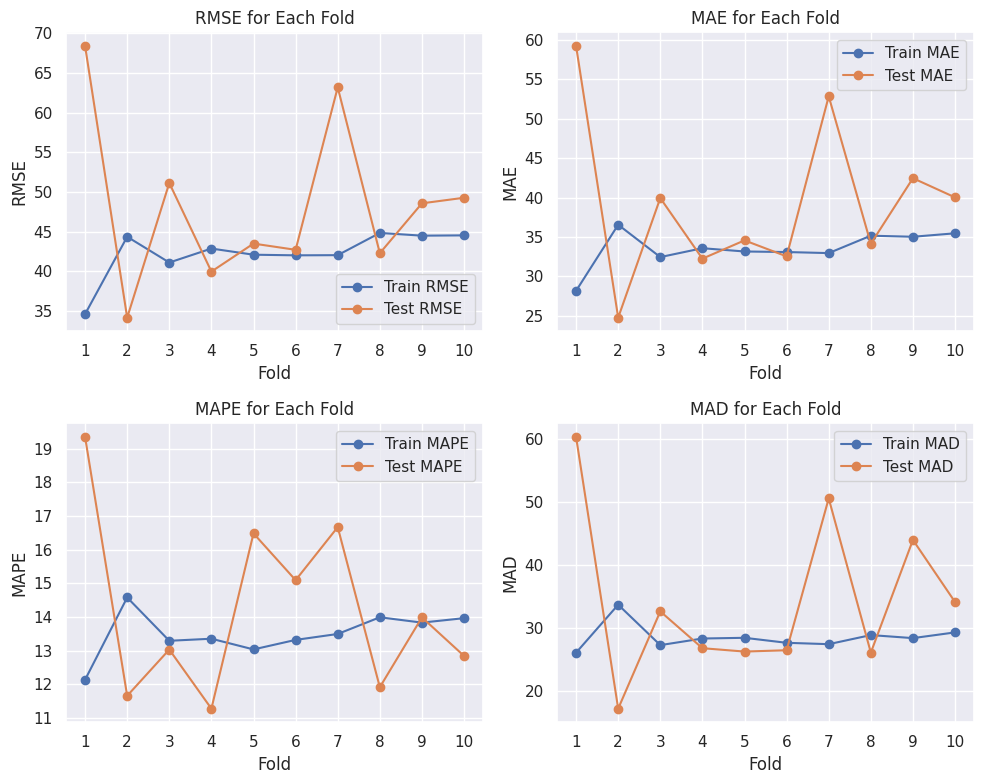

In [ ]:
# Create subplots for each performance metric
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Plotting RMSE for each fold
axes[0, 0].plot(range(1, 11), train_rmse_scores, marker='o', label='Train RMSE')
axes[0, 0].plot(range(1, 11), test_rmse_scores, marker='o', label='Test RMSE')
axes[0, 0].set_title('RMSE for Each Fold')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_xticks(range(1, 11))
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plotting MAE for each fold
axes[0, 1].plot(range(1, 11), train_mae_scores, marker='o', label='Train MAE')
axes[0, 1].plot(range(1, 11), test_mae_scores, marker='o', label='Test MAE')
axes[0, 1].set_title('MAE for Each Fold')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].set_xticks(range(1, 11))
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plotting MAPE for each fold
axes[1, 0].plot(range(1, 11), train_mape_scores, marker='o', label='Train MAPE')
axes[1, 0].plot(range(1, 11), test_mape_scores, marker='o', label='Test MAPE')
axes[1, 0].set_title('MAPE for Each Fold')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('MAPE')
axes[1, 0].set_xticks(range(1, 11))
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plotting MAPE for each fold
axes[1, 1].plot(range(1, 11), train_mad_scores, marker='o', label='Train MAD')
axes[1, 1].plot(range(1, 11), test_mad_scores, marker='o', label='Test MAD')
axes[1, 1].set_title('MAD for Each Fold')
axes[1, 1].set_xlabel('Fold')
axes[1, 1].set_ylabel('MAD')
axes[1, 1].set_xticks(range(1, 11))
axes[1, 1].legend()
axes[1, 1].grid(True)

# Hide the empty subplot
#axes[1, 1].axis('off')

# Adjust layout and display plot
plt.tight_layout()
plt.show()

**Applying Random Forest**

**with grid seach**

In [ ]:
# Selected columns
selected_columns = ['Month','Total_nitrogen','Avg_inflow', 'Avg_temp', 'Ammonia','Avg_humidity','BOD','COD','Avg_wind_speed']

# Subset features
X_train_subset = X_train_scaled_df[selected_columns]
X_test_subset = X_test_scaled_df[selected_columns]

# Define the Random Forest model
rf_model = RandomForestRegressor(n_estimators = 1600,random_state=42)

# Define the parameter grid to search
param_grid = {
    #'n_estimators': [500, 600, 800],        # Number of trees in the forest
    'max_depth': [ 10, 15, 20],              # Maximum depth of each tree
    'min_samples_split': [40, 50, 60],     # Minimum number of samples required to split an internal node
    'min_samples_leaf': [20, 30, 40]       # Minimum number of samples required to be at a leaf node
}

# Perform time series cross-validation
tscv = TimeSeriesSplit(n_splits=10)

# Perform grid search with cross-validation
grid_search = GridSearchCV(rf_model, param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(X_train_subset, y_train_cleaned)

# Get best parameters
best_params = grid_search.best_params_

# Print best parameters
print("Best Parameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_
print("Best Model:", best_model)

# Lists to store performance metrics for each fold
train_rmse_scores = []
test_rmse_scores = []
train_mae_scores = []
test_mae_scores = []
train_mape_scores = []
test_mape_scores = []
train_mad_scores = []
test_mad_scores = []

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(tscv.split(X_train_subset), 1):
    X_train_fold, X_test_fold = X_train_subset.iloc[train_index], X_train_subset.iloc[test_index]
    y_train_fold, y_test_fold = y_train_cleaned.iloc[train_index], y_train_cleaned.iloc[test_index]

    # Train the model on the training fold
    best_model.fit(X_train_fold, y_train_fold)

    # Predict on training and test sets
    y_train_pred = best_model.predict(X_train_fold)
    y_test_pred = best_model.predict(X_test_fold)

    # Calculate evaluation metrics
    train_rmse = np.sqrt(mean_squared_error(y_train_fold, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test_fold, y_test_pred))
    train_mae = mean_absolute_error(y_train_fold, y_train_pred)
    test_mae = mean_absolute_error(y_test_fold, y_test_pred)
    train_mape = np.mean(np.abs((y_train_fold - y_train_pred) / y_train_fold)) * 100
    test_mape = np.mean(np.abs((y_test_fold - y_test_pred) / y_test_fold)) * 100
    train_mad = median_absolute_error(y_train_fold, y_train_pred)
    test_mad = median_absolute_error(y_test_fold, y_test_pred)

    # Append scores to respective lists
    train_rmse_scores.append(train_rmse)
    test_rmse_scores.append(test_rmse)
    train_mae_scores.append(train_mae)
    test_mae_scores.append(test_mae)
    train_mape_scores.append(train_mape)
    test_mape_scores.append(test_mape)
    train_mad_scores.append(train_mad)
    test_mad_scores.append(test_mad)

    # Print performance metrics for each fold
    print(f"Fold {fold}:")
    print("Train RMSE:", train_rmse)
    print("Test RMSE:", test_rmse)
    print("Train MAE:", train_mae)
    print("Test MAE:", test_mae)
    print("Train MAPE:", train_mape)
    print("Test MAPE:", test_mape)
    print("Train MAD:", train_mad)
    print("Test MAD:", test_mad)
    print()

# Calculate average performance metrics across folds
avg_train_rmse = np.mean(train_rmse_scores)
avg_test_rmse = np.mean(test_rmse_scores)
avg_train_mae = np.mean(train_mae_scores)
avg_test_mae = np.mean(test_mae_scores)
avg_train_mape = np.mean(train_mape_scores)
avg_test_mape = np.mean(test_mape_scores)
avg_train_mad = np.mean(train_mad_scores)
avg_test_mad = np.mean(test_mad_scores)

# Print average performance metrics
print("Average Train RMSE:", avg_train_rmse)
print("Average Test RMSE:", avg_test_rmse)
print("Average Train MAE:", avg_train_mae)
print("Average Test MAE:", avg_test_mae)
print("Average Train MAPE:", avg_train_mape)
print("Average Test MAPE:", avg_test_mape)
print("Average Train MAD:", avg_train_mad)
print("Average Test MAD:", avg_test_mad)
print()

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 60, 'min_samples_split': 60}
Best Model: RandomForestRegressor(max_depth=10, min_samples_leaf=60, min_samples_split=60,
                      n_estimators=2000, random_state=42)
Fold 1:
Train RMSE: 34.59759519659231
Test RMSE: 66.06811893619745
Train MAE: 28.43239391130191
Test MAE: 56.73279910048433
Train MAPE: 12.396705736165476
Test MAPE: 18.49269300983313
Train MAD: 26.22684204736879
Test MAD: 57.7288420473688

Fold 2:
Train RMSE: 42.9916802433583
Test RMSE: 33.766906146187374
Train MAE: 35.431178219497376
Test MAE: 24.278178587442653
Train MAPE: 14.199119516702174
Test MAPE: 11.44400213822616
Train MAD: 31.92861830918511
Test MAD: 15.329118844950017

Fold 3:
Train RMSE: 33.752058438972774
Test RMSE: 46.42702190886753
Train MAE: 26.1466725967649
Test MAE: 37.92715834061472
Train MAPE: 10.780420950924787
Test MAPE: 12.593597265168082
Train MAD: 20.265375265312485
Test MAD: 32.095551045770236

Fold 4:
Train RMSE: 35.6409108900366

In [ ]:
# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=10)

# Selected columns
selected_columns = ['Month','Total_nitrogen','Avg_inflow', 'Avg_temp', 'Ammonia','Avg_humidity','BOD','Avg_wind_speed']

# Subset features
X_train_subset = X_train_scaled_df[selected_columns]
X_test_subset = X_test_scaled_df[selected_columns]

param_test1 = {'max_depth':range(10, 31, 5)}



# Instantiate Random Forest regressor
rf= RandomForestRegressor( n_estimators = 1600, min_samples_split=50, min_samples_leaf= 20, max_depth=10, random_state=42)
param_grid = param_test1

# Instantiate GridSearchCV
# Instantiate GridSearchCV
gsearch2 = GridSearchCV(estimator=rf, param_grid=param_test1, scoring='neg_mean_squared_error',cv=tscv)

# Fit GridSearchCV
gsearch2.fit(X_train_subset.iloc[train_index], y_train_cleaned.iloc[train_index])

# Retrieve results
best_params = gsearch2.best_params_
best_score = gsearch2.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)


Best Parameters: {'max_depth': 10}
Best Score: -2107.6677574747437


**RF without grid search**

In [15]:
# Selected columns
selected_columns = ['Month','Total_nitrogen','Avg_inflow', 'Avg_temp', 'Ammonia','Avg_humidity','BOD','COD','Avg_wind_speed']


# Subset features
X_train_subset = X_train_scaled_df[selected_columns]
X_test_subset = X_test_scaled_df[selected_columns]

# Define the Random Forest model with selected parameters
rf_model = RandomForestRegressor(max_depth=10, min_samples_leaf=20, min_samples_split=50,
                      n_estimators=1600, random_state=42)

# Initialize lists to store performance metrics for each fold
train_rmse_scores = []
train_mae_scores = []
train_mape_scores = []
train_mad_scores = []

test_rmse_scores = []
test_mae_scores = []
test_mape_scores = []
test_mad_scores = []

# Define time series cross-validation
tscv = TimeSeriesSplit(n_splits=10)

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(tscv.split(X_train_subset), 1):
    X_train_fold, X_test_fold = X_train_subset.iloc[train_index], X_train_subset.iloc[test_index]
    y_train_fold, y_test_fold = y_train_cleaned.iloc[train_index], y_train_cleaned.iloc[test_index]

    # Train the model on the training fold
    rf_model.fit(X_train_fold, y_train_fold)

    # Predict on training and test sets
    y_train_pred = rf_model.predict(X_train_fold)
    y_test_pred = rf_model.predict(X_test_fold)

    # Calculate evaluation metrics
    train_rmse = np.sqrt(mean_squared_error(y_train_fold, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test_fold, y_test_pred))
    train_mae = mean_absolute_error(y_train_fold, y_train_pred)
    test_mae = mean_absolute_error(y_test_fold, y_test_pred)
    train_mape = np.mean(np.abs((y_train_fold - y_train_pred) / y_train_fold)) * 100
    test_mape = np.mean(np.abs((y_test_fold - y_test_pred) / y_test_fold)) * 100
    train_mad = median_absolute_error(y_train_fold, y_train_pred)
    test_mad = median_absolute_error(y_test_fold, y_test_pred)

    # Append scores to respective lists
    train_rmse_scores.append(train_rmse)
    test_rmse_scores.append(test_rmse)
    train_mae_scores.append(train_mae)
    test_mae_scores.append(test_mae)
    train_mape_scores.append(train_mape)
    test_mape_scores.append(test_mape)
    train_mad_scores.append(train_mad)
    test_mad_scores.append(test_mad)

    # Print performance metrics for each fold
    print(f"Fold {fold}:")
    print("Train RMSE:", train_rmse)
    print("Test RMSE:", test_rmse)
    print("Train MAE:", train_mae)
    print("Test MAE:", test_mae)
    print("Train MAPE:", train_mape)
    print("Test MAPE:", test_mape)
    print("Train MAD:", train_mad)
    print("Test MAD:", test_mad)
    print()

# Calculate average performance metrics across folds
avg_train_rmse = np.mean(train_rmse_scores)
avg_test_rmse = np.mean(test_rmse_scores)
avg_train_mae = np.mean(train_mae_scores)
avg_test_mae = np.mean(test_mae_scores)
avg_train_mape = np.mean(train_mape_scores)
avg_test_mape = np.mean(test_mape_scores)
avg_train_mad = np.mean(train_mad_scores)
avg_test_mad = np.mean(test_mad_scores)

# Print average performance metrics
print("Average Train RMSE:", avg_train_rmse)
print("Average Test RMSE:", avg_test_rmse)
print("Average Train MAE:", avg_train_mae)
print("Average Test MAE:", avg_test_mae)
print("Average Train MAPE:", avg_train_mape)
print("Average Test MAPE:", avg_test_mape)
print("Average Train MAD:", avg_train_mad)
print("Average Test MAD:", avg_test_mad)
print()

Fold 1:
Train RMSE: 25.38875967093514
Test RMSE: 46.88110156323086
Train MAE: 20.396920553047167
Test MAE: 37.853008901480536
Train MAPE: 8.975801502771091
Test MAPE: 12.389013960665519
Train MAD: 17.009269388945768
Test MAD: 34.590122860187364

Fold 2:
Train RMSE: 29.192230725198446
Test RMSE: 43.61274733788227
Train MAE: 23.507874928974307
Test MAE: 33.83834117359484
Train MAPE: 9.281194961525676
Test MAPE: 14.994457687845616
Train MAD: 19.49659770462165
Test MAD: 29.25791677475152

Fold 3:
Train RMSE: 29.525021161313663
Test RMSE: 45.36177133047691
Train MAE: 22.49898583098128
Test MAE: 37.13971007933525
Train MAPE: 9.332960760880392
Test MAPE: 12.392441029381876
Train MAD: 18.02343002906946
Test MAD: 30.634121320562997

Fold 4:
Train RMSE: 31.607413724401376
Test RMSE: 35.842170553379354
Train MAE: 24.538102087239647
Test MAE: 28.714788424155536
Train MAPE: 9.803566397602868
Test MAPE: 10.568653278271533
Train MAD: 19.82930196833044
Test MAD: 25.26816028651791

Fold 5:
Train RMSE: 

**Visualization of performance metrics for RF**

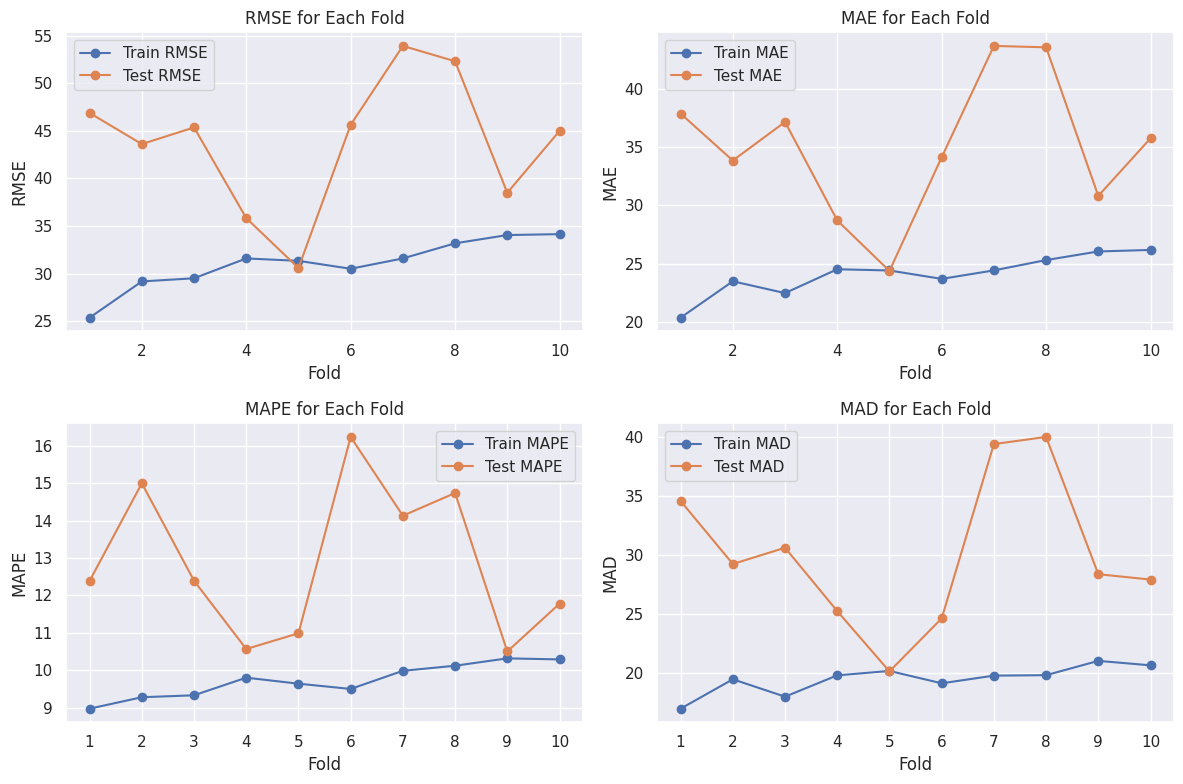

In [ ]:
# Define the number of folds
num_folds = len(train_rmse_scores)

# Create subplots for each performance metric
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Plot RMSE for each fold
axes[0, 0].plot(range(1, num_folds + 1), train_rmse_scores, label='Train RMSE', marker='o')
axes[0, 0].plot(range(1, num_folds + 1), test_rmse_scores, label='Test RMSE', marker='o')
axes[0, 0].set_title('RMSE for Each Fold')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].legend()

# Plot MAE for each fold
axes[0, 1].plot(range(1, num_folds + 1), train_mae_scores, label='Train MAE', marker='o')
axes[0, 1].plot(range(1, num_folds + 1), test_mae_scores, label='Test MAE', marker='o')
axes[0, 1].set_title('MAE for Each Fold')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].legend()

# Plotting MAPE for each fold
axes[1, 0].plot(range(1, num_folds + 1), train_mape_scores, marker='o', label='Train MAPE')
axes[1, 0].plot(range(1, num_folds + 1), test_mape_scores, marker='o', label='Test MAPE')
axes[1, 0].set_title('MAPE for Each Fold')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('MAPE')
axes[1, 0].set_xticks(range(1, 11))
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plotting MAD for each fold
axes[1, 1].plot(range(1, num_folds + 1), train_mad_scores, marker='o', label='Train MAD')
axes[1, 1].plot(range(1, num_folds + 1), test_mad_scores, marker='o', label='Test MAD')
axes[1, 1].set_title('MAD for Each Fold')
axes[1, 1].set_xlabel('Fold')
axes[1, 1].set_ylabel('MAD')
axes[1, 1].set_xticks(range(1, 11))
axes[1, 1].legend()
axes[1, 1].grid(True)

# Hide the empty subplot
#axes[1, 1].axis('off')

# Adjust layout and display plot
plt.tight_layout()
plt.show()


**Applying Gradient Boost**

In [ ]:
# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=10)

# Selected columns
selected_columns = ['Month','Total_nitrogen','Avg_inflow', 'Avg_temp', 'Ammonia','Avg_humidity','BOD','COD','Avg_wind_speed']

# Subset features
X_train_subset = X_train_scaled_df[selected_columns]
X_test_subset = X_test[selected_columns]

param_test3 = {'min_samples_split':range(80,501,20), 'min_samples_leaf':range(60,101,20)}

# Instantiate XGBoost regressor
gbr = GradientBoostingRegressor(learning_rate=0.01,n_estimators=200, min_samples_split=80, min_samples_leaf=80, max_depth=7, subsample=0.85, random_state=42)
param_grid = param_test3
#xgb_model = xgb.XGBRegressor(learning_rate=0.01, n_estimators=140, reg_alpha= 0.1, max_depth=4,
#                             min_child_weight=6, gamma=0.3, subsample=0.85, colsample_bytree=0.75, seed=27)

# Instantiate GridSearchCV
gsearch2 = GridSearchCV(estimator=gbr, param_grid=param_test3, scoring='neg_mean_squared_error',cv=tscv)

# Fit GridSearchCV
gsearch2.fit(X_train_subset.iloc[train_index], y_train_cleaned.iloc[train_index])

# Retrieve results
best_params = gsearch2.best_params_
best_score = gsearch2.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'min_samples_leaf': 80, 'min_samples_split': 80}
Best Score: -2145.0318834877176


**with grid search**

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

# Define function to calculate evaluation metrics
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true) * 100)
    mad = median_absolute_error(y_true, y_pred)
    return rmse, mae, mape, mad

# Define selected columns
selected_columns = ['Month','Total_nitrogen','Avg_inflow', 'Avg_temp', 'Ammonia','Avg_humidity','BOD','COD','Avg_wind_speed']

# Subset features
X_train_subset = X_train_scaled_df[selected_columns]
X_test_subset = X_test_scaled_df[selected_columns]

# Define parameter grid for grid search
param_grid = {
    'n_estimators': [30, 40, 50],              # Number of boosting stages
    'learning_rate': [0.001, 0.01, 0.1],       # Learning rate
    'max_depth': [5, 7, 9],                    # Maximum depth of each tree
    'min_samples_split': [1000, 2000, 3000],   # Minimum number of samples required to split an internal node
    'min_samples_leaf': [30, 50, 70],          # Minimum number of samples required to be at a leaf node
    'subsample':[0.7,0.8, 0.9]
    }

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=10)

# Initialize lists to store evaluation metrics for each fold
rmse_train_fold, mae_train_fold, mape_train_fold, mad_train_fold = [], [], [], []
rmse_test_fold, mae_test_fold, mape_test_fold, mad_test_fold = [], [], [], []

# Initialize grid search with Gradient Boosting Regressor
gbr = GradientBoostingRegressor()
grid_search = GridSearchCV(gbr, param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Perform time series cross-validation
for train_index, test_index in tscv.split(X_train_subset):
    X_train_cv, X_test_cv = X_train_subset.iloc[train_index], X_train_subset.iloc[test_index]
    y_train_cv, y_test_cv = y_train_cleaned.iloc[train_index], y_train_cleaned.iloc[test_index]

    # Fit grid search
    grid_search.fit(X_train_cv, y_train_cv)

    # Get best parameters
    best_params = grid_search.best_params_
    print("Best Parameters:", best_params)

    # Get best estimator from grid search
    best_gbr = grid_search.best_estimator_

    # Predict on training and test sets
    y_train_pred_cv = best_gbr.predict(X_train_cv)
    y_test_pred_cv = best_gbr.predict(X_test_cv)

    # Calculate evaluation metrics for each fold
    rmse_train_cv, mae_train_cv, mape_train_cv, mad_train_cv = calculate_metrics(y_train_cv, y_train_pred_cv)
    rmse_test_cv, mae_test_cv, mape_test_cv, mad_test_cv  = calculate_metrics(y_test_cv, y_test_pred_cv)

    # Append metrics for this fold
    rmse_train_fold.append(rmse_train_cv)
    mae_train_fold.append(mae_train_cv)
    mape_train_fold.append(mape_train_cv)
    mad_train_fold.append(mad_train_cv)
    rmse_test_fold.append(rmse_test_cv)
    mae_test_fold.append(mae_test_cv)
    mape_test_fold.append(mape_test_cv)
    mad_test_fold.append(mad_test_cv)

# Print evaluation metrics for each fold
for i in range(len(rmse_train_fold)):
    print(f"Fold {i+1}:")
    print("RMSE on Train Set:", rmse_train_fold[i])
    print("RMSE on Test Set:", rmse_test_fold[i])
    print("MAE on Train Set:", mae_train_fold[i])
    print("MAE on Test Set:", mae_test_fold[i])
    print("MAPE on Train Set:", mape_train_fold[i])
    print("MAPE on Test Set:", mape_test_fold[i])
    print("MAD on Train Set:", mad_train_fold[i])
    print("MAD on Test Set:", mad_test_fold[i])
    print()

# Get best parameters
best_params = grid_search.best_params_

# Print best parameters
print("Best Parameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_
print("Best Model:", best_model)

# Calculate average evaluation metrics across folds
avg_rmse_train = np.mean(rmse_train_fold)
avg_rmse_test = np.mean(rmse_test_fold)
avg_mae_train = np.mean(mae_train_fold)
avg_mae_test = np.mean(mae_test_fold)
avg_mape_train = np.mean(mape_train_fold)
avg_mape_test = np.mean(mape_test_fold)
avg_mad_train = np.mean(mad_train_fold)
avg_mad_test = np.mean(mad_test_fold)

# Print average evaluation metrics
print("Average RMSE on Train Set:", avg_rmse_train)
print("Average RMSE on Test Set:", avg_rmse_test)
print("Average MAE on Train Set:", avg_mae_train)
print("Average MAE on Test Set:", avg_mae_test)
print("Average MAPE Score on Train Set:", avg_mape_train)
print("Average MAPE Score on Test Set:", avg_mape_test)
print("Average MAD Score on Train Set:", avg_mad_train)
print("Average MAD Score on Test Set:", avg_mad_test)


Fitting 10 folds for each of 729 candidates, totalling 7290 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 30, 'min_samples_split': 3000, 'n_estimators': 50, 'subsample': 0.7}
Fitting 10 folds for each of 729 candidates, totalling 7290 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 9, 'min_samples_leaf': 50, 'min_samples_split': 1000, 'n_estimators': 40, 'subsample': 0.8}
Fitting 10 folds for each of 729 candidates, totalling 7290 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 9, 'min_samples_leaf': 70, 'min_samples_split': 3000, 'n_estimators': 40, 'subsample': 0.8}
Fitting 10 folds for each of 729 candidates, totalling 7290 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 9, 'min_samples_leaf': 70, 'min_samples_split': 2000, 'n_estimators': 30, 'subsample': 0.7}
Fitting 10 folds for each of 729 candidates, totalling 7290 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 30, 'min_samples_sp

**GB without grid search**

In [16]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
import numpy as np

# Define function to calculate evaluation metrics including MAPE
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true) * 100)
    mad = median_absolute_error(y_true, y_pred)
    return rmse, mae, mape, mad

# Define selected columns
selected_columns = ['Month','Total_nitrogen','Avg_inflow', 'Avg_temp', 'Ammonia','Avg_humidity','BOD','COD','Avg_wind_speed']

# Subset features
X_train_subset = X_train_scaled_df[selected_columns]
X_test_subset = X_test_scaled_df[selected_columns]

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=10)

# Initialize lists to store evaluation metrics for each fold
rmse_train_fold, mae_train_fold, mad_train_fold, mape_train_fold = [], [], [], []
rmse_test_fold, mae_test_fold, mad_test_fold, mape_test_fold = [], [], [], []

# Initialize Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(learning_rate=0.01,n_estimators=500, min_samples_split=200, min_samples_leaf=100, max_depth=15, subsample=0.85, random_state=42)

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(tscv.split(X_train_subset), 1):
    X_train_fold, X_test_fold = X_train_subset.iloc[train_index], X_train_subset.iloc[test_index]
    y_train_fold, y_test_fold = y_train_cleaned.iloc[train_index], y_train_cleaned.iloc[test_index]

    # Train the model on the training fold
    gbr_model.fit(X_train_fold, y_train_fold)

    # Predict on training and test sets
    y_train_pred = gbr_model.predict(X_train_fold)
    y_test_pred = gbr_model.predict(X_test_fold)

    # Calculate evaluation metrics
    train_rmse, train_mae, train_mape, train_mad = calculate_metrics(y_train_fold, y_train_pred)
    test_rmse, test_mae, test_mape, test_mad = calculate_metrics(y_test_fold, y_test_pred)

    # Append scores to respective lists
    rmse_train_fold.append(train_rmse)
    mae_train_fold.append(train_mae)
    mape_train_fold.append(train_mape)
    mad_train_fold.append(train_mad)

    rmse_test_fold.append(test_rmse)
    mae_test_fold.append(test_mae)
    mape_test_fold.append(test_mape)
    mad_test_fold.append(test_mad)

    # Print performance metrics for each fold
    print(f"Fold {fold}:")
    print("Train RMSE:", train_rmse)
    print("Test RMSE:", test_rmse)
    print("Train MAE:", train_mae)
    print("Test MAE:", test_mae)
    print("Train MAPE:", train_mape)
    print("Test MAPE:", test_mape)
    print("Train MAD:", train_mad)
    print("Test MAD:", test_mad)
    print()

# Calculate average performance metrics across folds
avg_train_rmse = np.mean(rmse_train_fold)
avg_test_rmse = np.mean(rmse_test_fold)
avg_train_mae = np.mean(mae_train_fold)
avg_test_mae = np.mean(mae_test_fold)
avg_train_mape = np.mean(mape_train_fold)
avg_test_mape = np.mean(mape_test_fold)
avg_train_mad = np.mean(mad_train_fold)
avg_test_mad = np.mean(mad_test_fold)


# Print average performance metrics
print("Average Train RMSE:", avg_train_rmse)
print("Average Test RMSE:", avg_test_rmse)
print("Average Train MAE:", avg_train_mae)
print("Average Test MAE:", avg_test_mae)
print("Average Train MAPE:", avg_train_mape)
print("Average Test MAPE:", avg_test_mape)
print("Average Train MAD:", avg_train_mad)
print("Average Test MAD:", avg_test_mad)
print()

Fold 1:
Train RMSE: 34.597620452154814
Test RMSE: 65.98235051369562
Train MAE: 28.442145659082048
Test MAE: 56.639329283000286
Train MAPE: 12.40631545160166
Test MAPE: 18.460919601657675
Train MAD: 26.123906931911705
Test MAD: 57.625906931911715

Fold 2:
Train RMSE: 44.914615046393266
Test RMSE: 34.99649467953081
Train MAE: 37.16230058167147
Test MAE: 25.43077822788098
Train MAPE: 14.904588901810925
Test MAPE: 11.990855341498344
Train MAD: 33.943
Test MAD: 18.05458823302584

Fold 3:
Train RMSE: 31.751401659792194
Test RMSE: 45.48474733682748
Train MAE: 24.280422104266176
Test MAE: 37.636418698250694
Train MAPE: 10.046816278542686
Test MAPE: 12.616979698083064
Train MAD: 19.11765439130471
Test MAD: 30.13636559690289

Fold 4:
Train RMSE: 33.73745851187232
Test RMSE: 35.42360405513767
Train MAE: 26.27802637369602
Test MAE: 28.509534729186104
Train MAPE: 10.490884269929216
Test MAPE: 10.424432174384197
Train MAD: 21.96936792278416
Test MAD: 26.96366982906204

Fold 5:
Train RMSE: 32.9162283

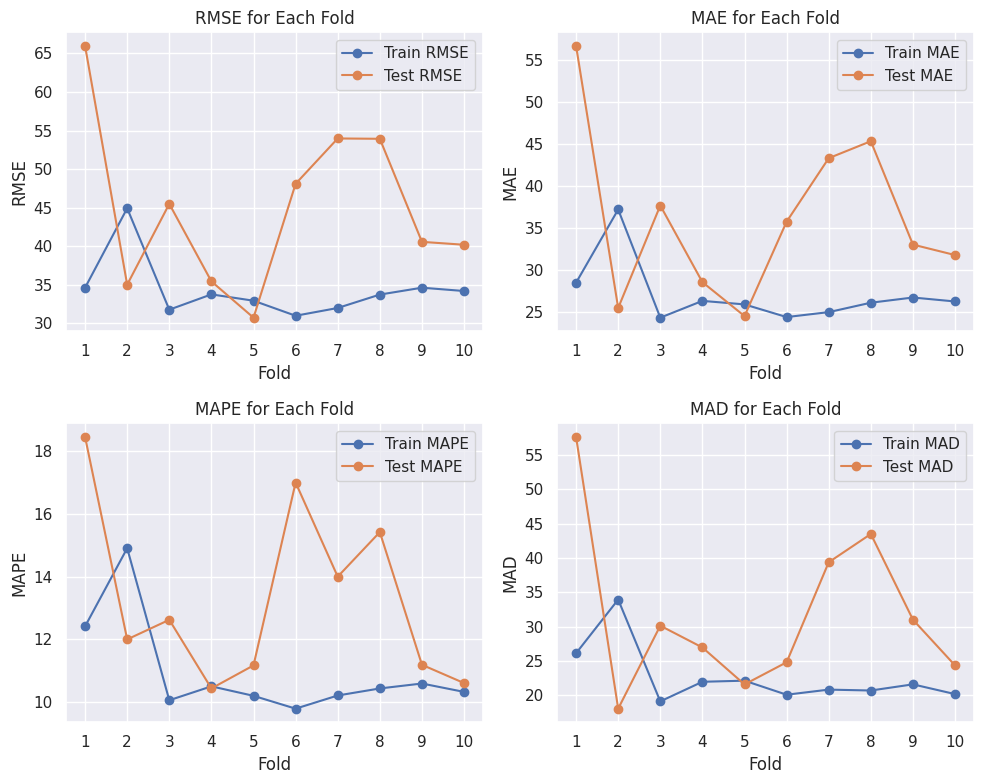

In [ ]:
# Create subplots for each performance metric
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Plotting RMSE for each fold
axes[0, 0].plot(range(1, 11), rmse_train_fold, marker='o', label='Train RMSE')
axes[0, 0].plot(range(1, 11), rmse_test_fold, marker='o', label='Test RMSE')
axes[0, 0].set_title('RMSE for Each Fold')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_xticks(range(1, 11))
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plotting MAE for each fold
axes[0, 1].plot(range(1, 11), mae_train_fold, marker='o', label='Train MAE')
axes[0, 1].plot(range(1, 11), mae_test_fold, marker='o', label='Test MAE')
axes[0, 1].set_title('MAE for Each Fold')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].set_xticks(range(1, 11))
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plotting MAPE for each fold
axes[1, 0].plot(range(1, 11), mape_train_fold, marker='o', label='Train MAPE')
axes[1, 0].plot(range(1, 11), mape_test_fold, marker='o', label='Test MAPE')
axes[1, 0].set_title('MAPE for Each Fold')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('MAPE')
axes[1, 0].set_xticks(range(1, 11))
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plotting MAD for each fold
axes[1, 1].plot(range(1, 11), mad_train_fold, marker='o', label='Train MAD')
axes[1, 1].plot(range(1, 11), mad_test_fold, marker='o', label='Test MAD')
axes[1, 1].set_title('MAD for Each Fold')
axes[1, 1].set_xlabel('Fold')
axes[1, 1].set_ylabel('MAD')
axes[1, 1].set_xticks(range(1, 11))
axes[1, 1].legend()
axes[1, 1].grid(True)

# Hide the empty subplot
#axes[1, 1].axis('off')

# Adjust layout and display plot
plt.tight_layout()
plt.show()

**Applying XGBoost**

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Selected columns
selected_columns = ['Month','Total_nitrogen','Avg_inflow', 'Avg_temp', 'Ammonia','Avg_humidity','BOD','COD','Avg_wind_speed']

# Subset features
X_train_subset = X_train_scaled_df[selected_columns]
X_test_subset = X_test_scaled_df[selected_columns]

# Define the XGBoost model
xgb_model = xgb.XGBRegressor()

# Define the parameter grid to search
param_grid = {
    'n_estimators': [1000, 2000, 3000],
    'max_depth': [9, 10, 11],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.5, 0.6, 0.78],
    'gamma': [0.3, 0.4, 0.5],
    'min_child_weight': [1, 2, 3],
    'reg_alpha': [0.1, 1, 10]
}

# Perform time series cross-validation
tscv = TimeSeriesSplit(n_splits=10)

# Initialize lists to store evaluation metrics for each fold
rmse_train_fold, mae_train_fold, r2_train_fold = [], [], []
rmse_test_fold, mae_test_fold, r2_test_fold = [], [], []

# Perform grid search with cross-validation
for train_index, test_index in tscv.split(X_train_subset):
    X_train_cv, X_test_cv = X_train_subset.iloc[train_index], X_train_subset.iloc[test_index]
    y_train_cv, y_test_cv = y_train_cleaned[train_index], y_train_cleaned[test_index]

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(xgb_model, param_grid, cv=tscv, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_cv, y_train_cv)

    # Get the best model
    best_model = grid_search.best_estimator_

    # Evaluate the model on train set
    y_train_pred_cv = best_model.predict(X_train_cv)
    rmse_train_fold.append(np.sqrt(mean_squared_error(y_train_cv, y_train_pred_cv)))
    mae_train_fold.append(mean_absolute_error(y_train_cv, y_train_pred_cv))
    r2_train_fold.append(r2_score(y_train_cv, y_train_pred_cv))

    # Evaluate the model on test set
    y_test_pred_cv = best_model.predict(X_test_cv)
    rmse_test_fold.append(np.sqrt(mean_squared_error(y_test_cv, y_test_pred_cv)))
    mae_test_fold.append(mean_absolute_error(y_test_cv, y_test_pred_cv))
    r2_test_fold.append(r2_score(y_test_cv, y_test_pred_cv))

# Display performance of each fold
for fold in range(10):
    print(f"Fold {fold+1}:")
    print("RMSE on Train Set:", rmse_train_fold[fold])
    print("MAE on Train Set:", mae_train_fold[fold])
    print("R2 Score on Train Set:", r2_train_fold[fold])
    print("RMSE on Test Set:", rmse_test_fold[fold])
    print("MAE on Test Set:", mae_test_fold[fold])
    print("R2 Score on Test Set:", r2_test_fold[fold])
    print()

# Calculate average evaluation metrics across folds
avg_rmse_train = np.mean(rmse_train_fold)
avg_rmse_test = np.mean(rmse_test_fold)
avg_mae_train = np.mean(mae_train_fold)
avg_mae_test = np.mean(mae_test_fold)
avg_r2_train = np.mean(r2_train_fold)
avg_r2_test = np.mean(r2_test_fold)

# Print average evaluation metrics
print("Average RMSE on Train Set:", avg_rmse_train)
print("Average RMSE on Test Set:", avg_rmse_test)
print("Average MAE on Train Set:", avg_mae_train)
print("Average MAE on Test Set:", avg_mae_test)
print("Average R2 Score on Train Set:", avg_r2_train)
print("Average R2 Score on Test Set:", avg_r2_test)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Selected columns
selected_columns = ['Month','Total_nitrogen','Avg_inflow', 'Avg_temp', 'Ammonia','Avg_humidity','BOD','COD','Avg_wind_speed']

# Subset features
X_train_subset = X_train_scaled_df[selected_columns]
X_test_subset = X_test_scaled_df[selected_columns]

param_test7 = {
 'reg_alpha':[0.09, 0.1, 0.5, 1.0]
}

# Instantiate XGBoost regressor
xgb_model = xgb.XGBRegressor(learning_rate=0.1, n_estimators=1000, reg_alpha= 0.1, max_depth=14,
                              min_child_weight=6, gamma=0.2, subsample=0.8, colsample_bytree=0.75, seed=27)

# Instantiate GridSearchCV
gsearch2 = GridSearchCV(estimator=xgb_model, param_grid=param_test7, scoring='neg_mean_squared_error',cv=5)

# Fit GridSearchCV
gsearch2.fit(X_train_subset.iloc[train_index], y_train_cleaned.iloc[train_index])

# Retrieve results
best_params = gsearch2.best_params_
best_score = gsearch2.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)


Best Parameters: {'reg_alpha': 0.1}
Best Score: -1873.6287697426858


In [17]:
# Define function to calculate evaluation metrics including MAPE
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true) * 100)
    mad = median_absolute_error(y_true, y_pred)
    return rmse, mae, mape, mad

# Selected columns
selected_columns = ['Month','Total_nitrogen','Avg_inflow', 'Avg_temp', 'Ammonia','Avg_humidity','BOD','COD','Avg_wind_speed']

# Subset features
X_train_subset = X_train_scaled_df[selected_columns]
X_test_subset = X_test_scaled_df[selected_columns]

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(learning_rate=0.0001, n_estimators=2000, reg_alpha= 15, max_depth=15,
                              min_child_weight=4, gamma=5, subsample=0.7, colsample_bytree=0.7, seed=42)

# Define time series cross-validation
tscv = TimeSeriesSplit(n_splits=10)

# Lists to store evaluation metrics for each fold
rmse_train_fold, mae_train_fold, mad_train_fold, mape_train_fold = [], [], [], []
rmse_test_fold, mae_test_fold, mad_test_fold, mape_test_fold = [], [], [], []


# Iterate through cross-validation splits
# Perform cross-validation
for fold, (train_index, test_index) in enumerate(tscv.split(X_train_subset), 1):
    X_train_fold, X_test_fold = X_train_subset.iloc[train_index], X_train_subset.iloc[test_index]
    y_train_fold, y_test_fold = y_train_cleaned.iloc[train_index], y_train_cleaned.iloc[test_index]

    # Train the model on the training fold
    xgb_model.fit(X_train_fold, y_train_fold)

    # Predict on training and test sets
    y_train_pred = xgb_model.predict(X_train_fold)
    y_test_pred = xgb_model.predict(X_test_fold)

    # Calculate evaluation metrics
    train_rmse, train_mae, train_mape, train_mad = calculate_metrics(y_train_fold, y_train_pred)
    test_rmse, test_mae, test_mape, test_mad = calculate_metrics(y_test_fold, y_test_pred)

    # Append scores to respective lists
    rmse_train_fold.append(train_rmse)
    mae_train_fold.append(train_mae)
    mape_train_fold.append(train_mape)
    mad_train_fold.append(train_mad)

    rmse_test_fold.append(test_rmse)
    mae_test_fold.append(test_mae)
    mape_test_fold.append(test_mape)
    mad_test_fold.append(test_mad)

    # Print performance metrics for each fold
    print(f"Fold {fold}:")
    print("Train RMSE:", train_rmse)
    print("Test RMSE:", test_rmse)
    print("Train MAE:", train_mae)
    print("Test MAE:", test_mae)
    print("Train MAPE:", train_mape)
    print("Test MAPE:", test_mape)
    print("Train MAD:", train_mad)
    print("Test MAD:", test_mad)
    print()

# Calculate average performance metrics across folds
avg_train_rmse = np.mean(rmse_train_fold)
avg_test_rmse = np.mean(rmse_test_fold)
avg_train_mae = np.mean(mae_train_fold)
avg_test_mae = np.mean(mae_test_fold)
avg_train_mape = np.mean(mape_train_fold)
avg_test_mape = np.mean(mape_test_fold)
avg_train_mad = np.mean(mad_train_fold)
avg_test_mad = np.mean(mad_test_fold)


# Print average performance metrics
print("Average Train RMSE:", avg_train_rmse)
print("Average Test RMSE:", avg_test_rmse)
print("Average Train MAE:", avg_train_mae)
print("Average Test MAE:", avg_test_mae)
print("Average Train MAPE:", avg_train_mape)
print("Average Test MAPE:", avg_test_mape)
print("Average Train MAD:", avg_train_mad)
print("Average Test MAD:", avg_test_mad)
print()

Fold 1:
Train RMSE: 31.395603892810115
Test RMSE: 62.69852649913473
Train MAE: 25.629737913754123
Test MAE: 53.12091569992592
Train MAPE: 11.186876902649969
Test MAPE: 17.27211260511479
Train MAD: 22.545910766601565
Test MAD: 53.08159362792969

Fold 2:
Train RMSE: 40.03197851908843
Test RMSE: 33.20314252922953
Train MAE: 32.81488715672755
Test MAE: 23.448348165577855
Train MAPE: 13.144568389503013
Test MAPE: 11.078048138951404
Train MAD: 29.467476745605467
Test MAD: 16.154815917968733

Fold 3:
Train RMSE: 37.62519231216872
Test RMSE: 49.264835400906534
Train MAE: 29.544862163104092
Test MAE: 38.209835691956265
Train MAPE: 12.1713890820483
Test MAPE: 12.47832194232705
Train MAD: 25.205695312499984
Test MAD: 31.60396069335937

Fold 4:
Train RMSE: 39.193517336936985
Test RMSE: 38.39533977987173
Train MAE: 30.587436969199874
Test MAE: 31.02463417912626
Train MAPE: 12.221763639403132
Test MAPE: 10.94045056515836
Train MAD: 25.822207763671884
Test MAD: 26.282644531250014

Fold 5:
Train RMSE:

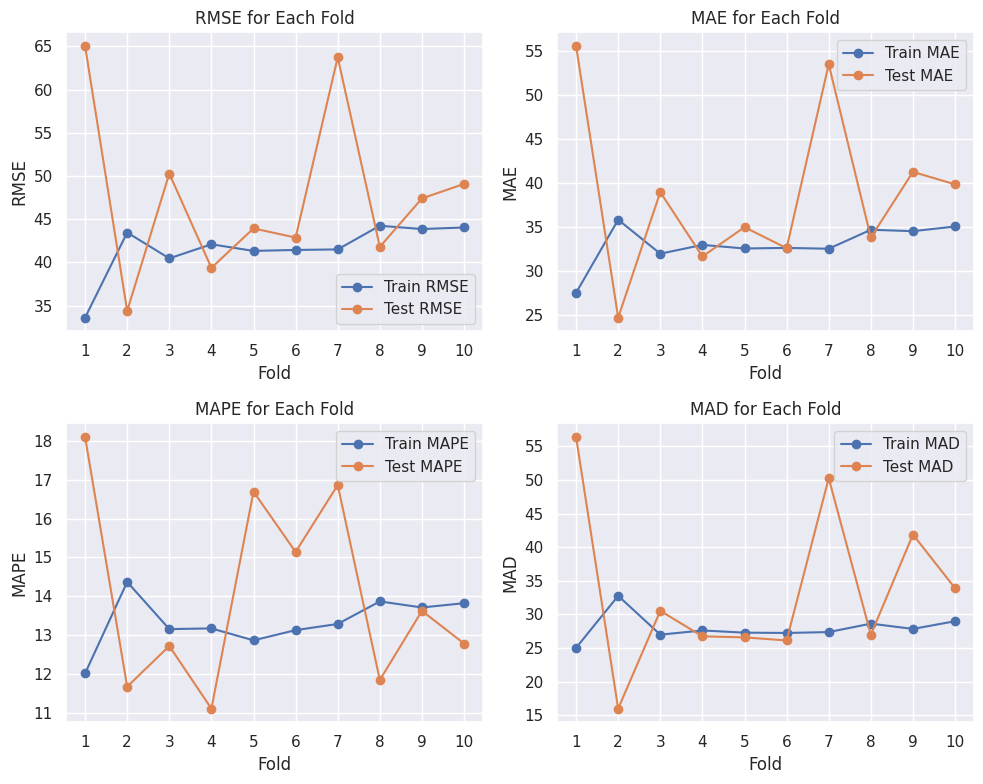

In [ ]:
# Create subplots for each performance metric
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Plotting RMSE for each fold
axes[0, 0].plot(range(1, 11), rmse_train_fold, marker='o', label='Train RMSE')
axes[0, 0].plot(range(1, 11), rmse_test_fold, marker='o', label='Test RMSE')
axes[0, 0].set_title('RMSE for Each Fold')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_xticks(range(1, 11))
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plotting MAE for each fold
axes[0, 1].plot(range(1, 11), mae_train_fold, marker='o', label='Train MAE')
axes[0, 1].plot(range(1, 11), mae_test_fold, marker='o', label='Test MAE')
axes[0, 1].set_title('MAE for Each Fold')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].set_xticks(range(1, 11))
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plotting MAPE for each fold
axes[1, 0].plot(range(1, 11), mape_train_fold, marker='o', label='Train MAPE')
axes[1, 0].plot(range(1, 11), mape_test_fold, marker='o', label='Test MAPE')
axes[1, 0].set_title('MAPE for Each Fold')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('MAPE')
axes[1, 0].set_xticks(range(1, 11))
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plotting MAPE for each fold
axes[1, 1].plot(range(1, 11), mad_train_fold, marker='o', label='Train MAD')
axes[1, 1].plot(range(1, 11), mad_test_fold, marker='o', label='Test MAD')
axes[1, 1].set_title('MAD for Each Fold')
axes[1, 1].set_xlabel('Fold')
axes[1, 1].set_ylabel('MAD')
axes[1, 1].set_xticks(range(1, 11))
axes[1, 1].legend()
axes[1, 1].grid(True)

# Adjust layout and display plot
plt.tight_layout()
plt.show()

In [ ]:
!pip install tensorflow
!pip install keras

In [18]:
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 35.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.2.1 which is incompatible.


In [1]:
import tensorflow as tf
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from scikeras.wrappers import KerasRegressor
from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from sklearn.model_selection import TimeSeriesSplit

**Applying ANN**

In [12]:
# Define a time series cross-validation strategy
tscv = TimeSeriesSplit(n_splits=10)

# Selected_columns
selected_columns = ['Month', 'Total_nitrogen', 'Avg_inflow', 'Avg_temp', 'Ammonia', 'Avg_humidity', 'BOD', 'COD', 'Avg_wind_speed']

# Subset features
X_train_subset = X_train_scaled_df[selected_columns]
X_test_subset = X_test_scaled_df[selected_columns]

# Fix random seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Create the model
def create_model(learning_rate=0.1):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model = Sequential([
        Dense(50, activation='relu', kernel_regularizer=regularizers.l1(0.1), input_shape=(len(selected_columns),)),
        Dropout(0.3),
        Dense(50, activation='relu', kernel_regularizer=regularizers.l1(0.1)),
        Dropout(0.3),
        Dense(50, activation='relu', kernel_regularizer=regularizers.l1(0.1)),
        Dropout(0.3),
        Dense(20, activation='relu', kernel_regularizer=regularizers.l1(0.1)),
        Dense(1)
    ])
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_absolute_error')
    return model


# Create KerasRegressor
keras_model = KerasRegressor(model=create_model, verbose=0)

# Define grid search parameters
param_grid = {
    'epochs': [50, 100],
}

# Define functions to calculate MAPE and MAD
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_deviation(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Perform grid search with 10-fold time series cross-validation
grid_search = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=tscv, scoring='neg_mean_absolute_error')
grid_search_result = grid_search.fit(X_train_subset, y_train_cleaned)

# Get the best parameters
best_params = grid_search_result.best_params_
print("Best Parameters:", best_params)

# Get the best model
best_model = grid_search_result.best_estimator_

# Initialize lists to store performance metrics for each fold and dataset
train_rmse_scores = []
train_mae_scores = []
train_mape_scores = []
train_mad_scores = []

test_rmse_scores = []
test_mae_scores = []
test_mape_scores = []
test_mad_scores = []

# Loop through each fold and evaluate the model
for fold, (train_index, test_index) in enumerate(tscv.split(X_train_subset)):
    X_train_cv, X_test_cv = X_train_subset.iloc[train_index], X_train_subset.iloc[test_index]
    y_train_cv, y_test_cv = y_train_cleaned.iloc[train_index], y_train_cleaned.iloc[test_index]

    # Fit the model on the training data for the current fold
    best_model.fit(X_train_cv, y_train_cv, batch_size=64, epochs=best_params['epochs'], verbose=0)

    # Predict on the training data for the current fold
    y_pred_train = best_model.predict(X_train_cv)

    # Predict on the test data for the current fold
    y_pred_test = best_model.predict(X_test_cv)

    # Calculate evaluation metrics for the training set for the current fold
    train_rmse = np.sqrt(mean_squared_error(y_train_cv, y_pred_train))
    train_mae = mean_absolute_error(y_train_cv, y_pred_train)
    train_mape = mean_absolute_percentage_error(y_train_cv, y_pred_train)
    train_mad = mean_absolute_deviation(y_train_cv, y_pred_train)

    # Calculate evaluation metrics for the test set for the current fold
    test_rmse = np.sqrt(mean_squared_error(y_test_cv, y_pred_test))
    test_mae = mean_absolute_error(y_test_cv, y_pred_test)
    test_mape = mean_absolute_percentage_error(y_test_cv, y_pred_test)
    test_mad = mean_absolute_deviation(y_test_cv, y_pred_test)

    # Append the metrics to the respective lists
    train_rmse_scores.append(train_rmse)
    train_mae_scores.append(train_mae)
    train_mape_scores.append(train_mape)
    train_mad_scores.append(train_mad)

    test_rmse_scores.append(test_rmse)
    test_mae_scores.append(test_mae)
    test_mape_scores.append(test_mape)
    test_mad_scores.append(test_mad)

    # Print the performance metrics for the current fold
    print(f"Fold {fold + 1}:")
    print("Training Set - RMSE:", train_rmse, "MAE:", train_mae, "MAPE:", train_mape, "MAD:", train_mad)
    print("Test Set - RMSE:", test_rmse, "MAE:", test_mae, "MAPE:", test_mape, "MAD:", test_mad)

# Calculate average performance metrics across folds
avg_train_rmse = np.mean(train_rmse_scores)
avg_test_rmse = np.mean(test_rmse_scores)
avg_train_mae = np.mean(train_mae_scores)
avg_test_mae = np.mean(test_mae_scores)
avg_train_mape = np.mean(train_mape_scores)
avg_test_mape = np.mean(test_mape_scores)
avg_train_mad = np.mean(train_mad_scores)
avg_test_mad = np.mean(test_mad_scores)

# Print average performance metrics
print("Average Train RMSE:", avg_train_rmse)
print("Average Test RMSE:", avg_test_rmse)
print("Average Train MAE:", avg_train_mae)
print("Average Test MAE:", avg_test_mae)
print("Average Train MAPE:", avg_train_mape)
print("Average Test MAPE:", avg_test_mape)
print("Average Train MAD:", avg_train_mad)
print("Average Test MAD:", avg_test_mad)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Best Parameters: {'epochs': 100}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1:
Training Set - RMSE: 28.63150300944961 MAE: 22.942619690583882 MAPE: 9.583860792157319 MAD: 22.942619690583882
Test Set - RMSE: 52.19044213527124 MAE: 43.19165837570716 MAPE: 14.075293471696506 MAD: 43.19165837570716


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 2:
Training Set - RMSE: 30.90932885403234 MAE: 24.85022175883199 MAPE: 9.610806401930711 MAD: 24.85022175883199
Test Set - RMSE: 41.11735513590792 MAE: 31.356222426140445 MAPE: 13.945947352780017 MAD: 31.356222426140445


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 3:
Training Set - RMSE: 36.93108502795589 MAE: 28.47623318560859 MAPE: 11.35987892280221 MAD: 28.47623318560859
Test Set - RMSE: 53.10564082793662 MAE: 42.357695545415766 MAPE: 13.80701503973881 MAD: 42.357695545415766


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 4:
Training Set - RMSE: 37.81150653030649 MAE: 29.57261587524414 MAPE: 11.763509023222888 MAD: 29.57261587524414
Test Set - RMSE: 36.96286219385809 MAE: 30.276732910156248 MAPE: 10.806056966717206 MAD: 30.276732910156248


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 5:
Training Set - RMSE: 37.15269636576152 MAE: 29.490696614491483 MAPE: 11.758677664113817 MAD: 29.490696614491483
Test Set - RMSE: 36.976110219950655 MAE: 28.152554457390448 MAPE: 13.408406787224802 MAD: 28.152554457390448


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 6:
Training Set - RMSE: 39.16982336112177 MAE: 30.456654853101046 MAPE: 12.176229016481363 MAD: 30.456654853101046
Test Set - RMSE: 43.16512385902522 MAE: 32.579108426499644 MAPE: 15.2705388960234 MAD: 32.579108426499644


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 7:
Training Set - RMSE: 38.68204744724227 MAE: 30.501347481552937 MAPE: 12.229595126491432 MAD: 30.501347481552937
Test Set - RMSE: 59.31791035767901 MAE: 48.90398010253905 MAPE: 15.55870943794282 MAD: 48.90398010253905


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 8:
Training Set - RMSE: 41.136869279132235 MAE: 32.37084454050932 MAPE: 12.884364592688238 MAD: 32.37084454050932
Test Set - RMSE: 45.44627688983186 MAE: 37.109825620453925 MAPE: 12.697186272066693 MAD: 37.109825620453925


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 9:
Training Set - RMSE: 43.16546941974821 MAE: 34.008436006143334 MAPE: 13.420978095162711 MAD: 34.008436006143334
Test Set - RMSE: 47.67701688790189 MAE: 40.95683459612967 MAPE: 13.513659845942113 MAD: 40.95683459612967


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 10:
Training Set - RMSE: 43.11958798349355 MAE: 34.27431068952208 MAPE: 12.977004437945741 MAD: 34.27431068952208
Test Set - RMSE: 55.37358154178397 MAE: 46.790943134877864 MAPE: 14.969755872601729 MAD: 46.790943134877864
Average Train RMSE: 37.670991727824386
Average Test RMSE: 47.13323200491465
Average Train MAE: 29.694398069558883
Average Test MAE: 38.167555559531024
Average Train MAPE: 11.776490407299644
Average Test MAPE: 13.80525699427341
Average Train MAD: 29.694398069558883
Average Test MAD: 38.167555559531024


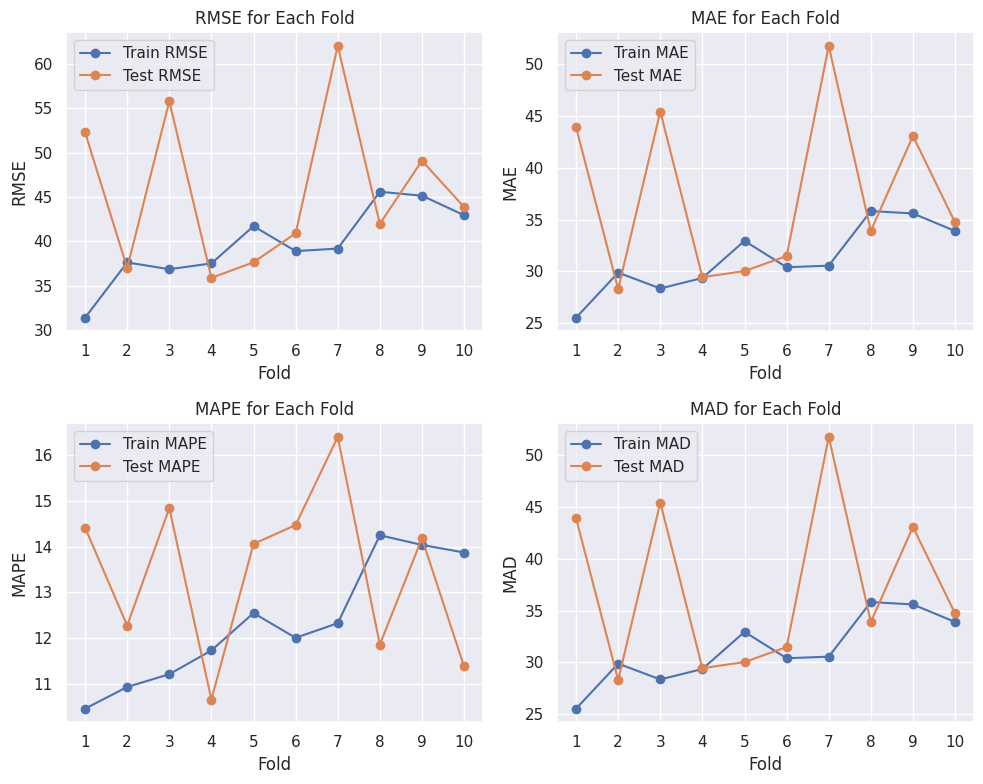

In [32]:
# Create subplots for each performance metric
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Plotting RMSE for each fold
axes[0, 0].plot(range(1, 11), train_rmse_scores, marker='o', label='Train RMSE')
axes[0, 0].plot(range(1, 11), test_rmse_scores, marker='o', label='Test RMSE')
axes[0, 0].set_title('RMSE for Each Fold')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_xticks(range(1, 11))
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plotting MAE for each fold
axes[0, 1].plot(range(1, 11), train_mae_scores, marker='o', label='Train MAE')
axes[0, 1].plot(range(1, 11), test_mae_scores, marker='o', label='Test MAE')
axes[0, 1].set_title('MAE for Each Fold')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].set_xticks(range(1, 11))
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plotting MAPE for each fold
axes[1, 0].plot(range(1, 11), train_mape_scores, marker='o', label='Train MAPE')
axes[1, 0].plot(range(1, 11), test_mape_scores, marker='o', label='Test MAPE')
axes[1, 0].set_title('MAPE for Each Fold')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('MAPE')
axes[1, 0].set_xticks(range(1, 11))
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plotting MAPE for each fold
axes[1, 1].plot(range(1, 11), train_mad_scores, marker='o', label='Train MAD')
axes[1, 1].plot(range(1, 11), test_mad_scores, marker='o', label='Test MAD')
axes[1, 1].set_title('MAD for Each Fold')
axes[1, 1].set_xlabel('Fold')
axes[1, 1].set_ylabel('MAD')
axes[1, 1].set_xticks(range(1, 11))
axes[1, 1].legend()
axes[1, 1].grid(True)

# Hide the empty subplot
#axes[1, 1].axis('off')

# Adjust layout and display plot
plt.tight_layout()
plt.show()


**Applying CNN**

In [14]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, AveragePooling1D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l1
from scikeras.wrappers import KerasRegressor
from keras import regularizers

In [15]:
# Define custom scoring functions for MAD and MAPE score
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_deviation(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def custom_mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define checkpoint callback
checkpoint = ModelCheckpoint('model_weights.weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)


# Selected columns
selected_columns = ['Month', 'Total_nitrogen', 'Avg_inflow', 'Avg_temp', 'Ammonia', 'Avg_humidity', 'BOD', 'COD', 'Avg_wind_speed']

# Subset features
X_train_subset = X_train_scaled_df[selected_columns]
X_test_subset = X_test_scaled_df[selected_columns]

# Initialize time series cross-validation
tscv = TimeSeriesSplit(n_splits=10)

# Lists to store evaluation metrics for each fold
train_rmse_list, train_mae_list, train_mape_list, train_mad_list = [], [], [], []
test_rmse_list, test_mae_list, test_mape_list, test_mad_list = [], [], [], []

# Function to create the CNN model
def create_cnn_model():
    model = Sequential([
        Conv1D(filters=96, kernel_size=2, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
        AveragePooling1D(pool_size=2),
        Conv1D(filters=96, kernel_size=2, activation='relu'),
        AveragePooling1D(pool_size=1),
        Conv1D(filters=96, kernel_size=2, activation='relu'),
        AveragePooling1D(pool_size=1),
        Flatten(),
        Dense(50, activation='relu', kernel_regularizer=regularizers.l1(0.001)),
        Dropout(0.3),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_absolute_error')

    return model

# Function to build the KerasRegressor
keras_regressor = KerasRegressor(model=create_cnn_model, epochs=100, batch_size=32, verbose=1)

# Perform time series cross-validation
for fold_idx, (train_index, test_index) in enumerate(tscv.split(X_train_subset)):
    X_train_fold, X_test_fold = X_train_subset.iloc[train_index], X_train_subset.iloc[test_index]
    y_train_fold, y_test_fold = y_train_cleaned.iloc[train_index], y_train_cleaned.iloc[test_index]

    # Reshape data for CNN input
    X_train_seq = np.reshape(X_train_fold.values, (X_train_fold.shape[0], X_train_fold.shape[1], 1))
    X_test_seq = np.reshape(X_test_fold.values, (X_test_fold.shape[0], X_test_fold.shape[1], 1))

    # Train the model
    history = keras_regressor.fit(X_train_seq, y_train_fold, validation_split=0.3, callbacks=[early_stopping, checkpoint])

    # Make predictions
    train_predictions = keras_regressor.predict(X_train_seq)
    test_predictions = keras_regressor.predict(X_test_seq)

    # Calculate evaluation metrics for train set
    train_rmse = np.sqrt(mean_squared_error(y_train_fold, train_predictions))
    train_mae = custom_mae(y_train_fold, train_predictions)
    train_mape = mean_absolute_percentage_error(y_train_fold, train_predictions)
    train_mad = np.median(np.abs(np.subtract(y_train_fold, train_predictions)))

    # Calculate evaluation metrics for test set
    test_rmse = np.sqrt(mean_squared_error(y_test_fold, test_predictions))
    test_mae = custom_mae(y_test_fold, test_predictions)
    test_mape = mean_absolute_percentage_error(y_test_fold, test_predictions)
    test_mad = np.median(np.abs(np.subtract(y_test_fold, test_predictions)))

    # Print evaluation metrics for the current fold
    print(f"Fold {fold_idx + 1} - Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
    print(f"Fold {fold_idx + 1} - Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
    print(f"Fold {fold_idx + 1} - Train MAPE: {train_mape:.4f}, Test MAPE: {test_mape:.4f}")
    print(f"Fold {fold_idx + 1} - Train MAD: {train_mad:.4f}, Test MAD: {test_mad:.4f}")
    print()

    # Append evaluation metrics to lists
    train_rmse_list.append(train_rmse)
    train_mae_list.append(train_mae)
    train_mape_list.append(train_mape)
    train_mad_list.append(train_mad)

    test_rmse_list.append(test_rmse)
    test_mae_list.append(test_mae)
    test_mape_list.append(test_mape)
    test_mad_list.append(test_mad)

# Calculate average evaluation metrics across all folds
avg_train_rmse = np.mean(train_rmse_list)
avg_train_mae = np.mean(train_mae_list)
avg_train_mape = np.mean(train_mape_list)
avg_train_mad = np.mean(train_mad_list)

avg_test_rmse = np.mean(test_rmse_list)
avg_test_mae = np.mean(test_mae_list)
avg_test_mape = np.mean(test_mape_list)
avg_test_mad = np.mean(test_mad_list)

# Display average evaluation metrics
print("Average Train RMSE:", avg_train_rmse)
print("Average Test RMSE:", avg_test_rmse)
print("Average Train MAE:", avg_train_mae)
print("Average Test MAE:", avg_test_mae)
print("Average Train MAPE:", avg_train_mape)
print("Average Test MAPE:", avg_test_mape)
print("Average Train MAD:", avg_train_mad)
print("Average Test MAD:", avg_test_mad)
print()

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 223.0539 - val_loss: 260.6383
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 222.8977 - val_loss: 260.4573
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 222.6745 - val_loss: 260.1688
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 222.3282 - val_loss: 259.7103
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 221.7673 - val_loss: 258.9864
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 220.8916 - val_loss: 257.8430
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 219.6136 - val_loss: 256.0571
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 217.4868 - val_loss: 253.3121
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 214.4517 - val_loss: 249.1420
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 208.9105 - val_loss: 242.9144
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 201.6026 - val_loss: 233.7732
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 244.3282 - val_loss: 298.9800
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 244.2133 - val_loss: 298.8497
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 244.0727 - val_loss: 298.6265
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 243.8332 - val_loss: 298.1918
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 243.3122 - val_loss: 297.3633
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 242.4362 - val_loss: 295.8290
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 240.7038 - val_loss: 293.0950
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 237.8066 - val_loss: 288.3554
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 232.8845 - val_loss: 280.3565
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 224.1097 - val_loss: 267.2099
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 209.8467 - val_loss: 246.2906
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 261.8970 - val_loss: 245.0384
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 261.3104 - val_loss: 243.7096
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 259.8082 - val_loss: 240.2453
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 255.6844 - val_loss: 231.9830
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 246.7660 - val_loss: 213.8285
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 226.9824 - val_loss: 176.6884
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 187.2474 - val_loss: 106.2509
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 114.2216 - val_loss: 55.3407
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 68.7641 - val_loss: 93.8587
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 70.6457 - val_loss: 53.9193
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 63.5513 - val_loss: 48.7431
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 254.9893 - val_loss: 281.0526
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 254.3617 - val_loss: 279.5570
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 252.3610 - val_loss: 274.7126
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 245.8306 - val_loss: 260.6526
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 228.3432 - val_loss: 224.7269
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 185.6888 - val_loss: 142.5109
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 102.5098 - val_loss: 59.6425
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 76.6032 - val_loss: 59.7972
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 67.6270 - val_loss: 73.2980
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 65.7578 - val_loss: 66.2571
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 56.8388 - val_loss: 55.6974
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 258.7601 - val_loss: 286.2487
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 256.9801 - val_loss: 280.1886
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 248.3019 - val_loss: 254.8549
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 215.2269 - val_loss: 170.6015
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 117.3441 - val_loss: 69.7465
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 76.8480 - val_loss: 59.4808
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 61.0660 - val_loss: 66.8662
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 63.5060 - val_loss: 54.2366
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 50.8470 - val_loss: 54.6791
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 52.5615 - val_loss: 50.7336
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 55.4865 - val_loss: 50.2596
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 261.0325 - val_loss: 256.7821
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 258.2437 - val_loss: 245.3440
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 241.1903 - val_loss: 189.1646
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 165.4822 - val_loss: 61.9622
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 72.7751 - val_loss: 64.2290
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 61.0669 - val_loss: 54.6231
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 57.3594 - val_loss: 59.3681
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 55.2897 - val_loss: 50.3527
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 54.4759 - val_loss: 49.1420
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 53.5621 - val_loss: 46.0719
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 56.1339 - val_loss: 43.7682
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 266.6320 - val_loss: 244.8089
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 263.1551 - val_loss: 227.0257
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 236.7093 - val_loss: 121.9143
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 120.1149 - val_loss: 140.0414
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 78.6743 - val_loss: 54.7920
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 63.4973 - val_loss: 65.4221
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 59.9394 - val_loss: 50.5986
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 58.5233 - val_loss: 45.6760
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 53.5733 - val_loss: 44.7902
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 51.1215 - val_loss: 41.9632
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 52.7310 - val_loss: 45.7316
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 260.9651 - val_loss: 269.4327
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 256.2549 - val_loss: 243.8199
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 215.4595 - val_loss: 94.7542
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 79.6923 - val_loss: 74.1897
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 63.1076 - val_loss: 68.7262
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 60.1129 - val_loss: 63.9048
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 56.2565 - val_loss: 58.0527
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 54.0928 - val_loss: 54.1907
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 52.1531 - val_loss: 51.3089
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 51.9064 - val_loss: 48.6626
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 49.8340 - val_loss: 47.0909
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 257.5215 - val_loss: 282.6788
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 252.1035 - val_loss: 248.6469
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 196.2340 - val_loss: 77.0352
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 73.8029 - val_loss: 72.6664
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 64.9564 - val_loss: 65.7222
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 63.0656 - val_loss: 61.8835
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 63.1795 - val_loss: 58.8495
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 58.0772 - val_loss: 55.6611
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 59.6109 - val_loss: 51.1033
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 59.2757 - val_loss: 49.2157
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 55.8934 - val_loss: 48.8440
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 261.0571 - val_loss: 289.5414
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 245.6535 - val_loss: 187.2494
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 117.1445 - val_loss: 71.7054
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 66.8914 - val_loss: 67.3013
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 60.9655 - val_loss: 74.7809
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 56.0067 - val_loss: 58.4385
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 50.7519 - val_loss: 57.5345
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 48.1311 - val_loss: 57.5468
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 46.1027 - val_loss: 55.6129
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 46.0782 - val_loss: 49.2644
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 44.5901 - val_loss: 56.8799
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11

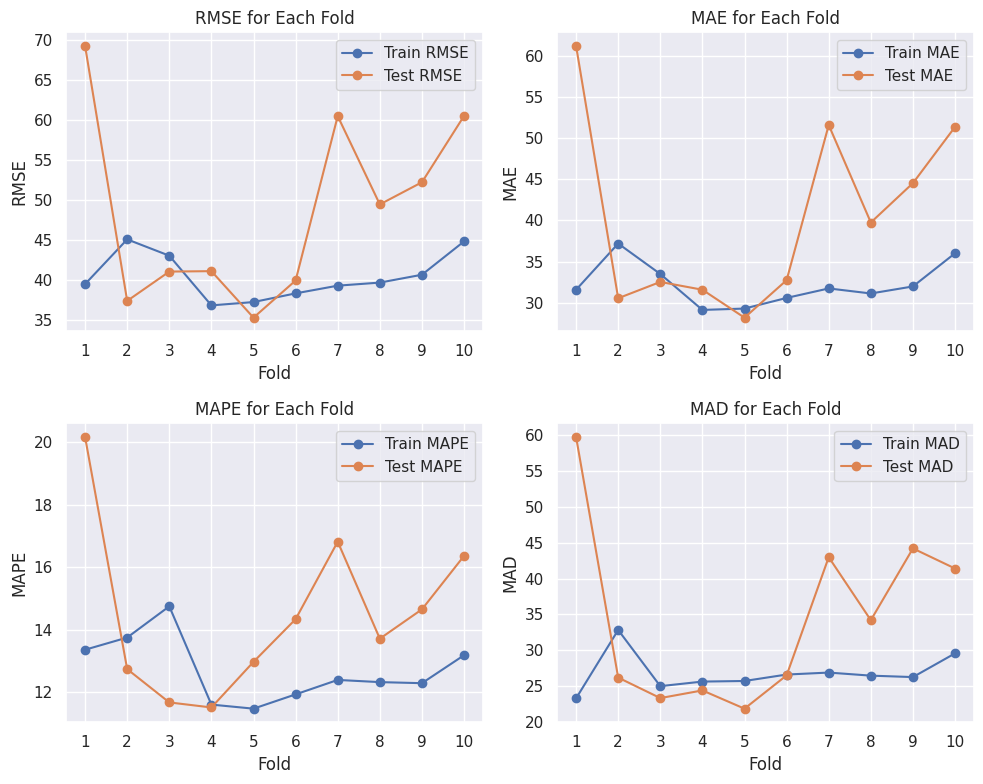

In [14]:
# Create subplots for each performance metric
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Plotting RMSE for each fold
axes[0, 0].plot(range(1, 11), train_rmse_list, marker='o', label='Train RMSE')
axes[0, 0].plot(range(1, 11), test_rmse_list, marker='o', label='Test RMSE')
axes[0, 0].set_title('RMSE for Each Fold')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_xticks(range(1, 11))
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plotting MAE for each fold
axes[0, 1].plot(range(1, 11), train_mae_list, marker='o', label='Train MAE')
axes[0, 1].plot(range(1, 11), test_mae_list, marker='o', label='Test MAE')
axes[0, 1].set_title('MAE for Each Fold')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].set_xticks(range(1, 11))
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plotting MAPE for each fold
axes[1, 0].plot(range(1, 11), train_mape_list, marker='o', label='Train MAPE')
axes[1, 0].plot(range(1, 11), test_mape_list, marker='o', label='Test MAPE')
axes[1, 0].set_title('MAPE for Each Fold')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('MAPE')
axes[1, 0].set_xticks(range(1, 11))
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plotting MAD for each fold
axes[1, 1].plot(range(1, 11), train_mad_list, marker='o', label='Train MAD')
axes[1, 1].plot(range(1, 11), test_mad_list, marker='o', label='Test MAD')
axes[1, 1].set_title('MAD for Each Fold')
axes[1, 1].set_xlabel('Fold')
axes[1, 1].set_ylabel('MAD')
axes[1, 1].set_xticks(range(1, 11))
axes[1, 1].legend()
axes[1, 1].grid(True)

# Adjust layout and display plot
plt.tight_layout()
plt.show()

**Applying LSTM**

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l1
from sklearn.model_selection import TimeSeriesSplit
from keras.optimizers import Adam


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_deviation(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Define selected columns
selected_columns = ['Month', 'Total_nitrogen', 'Avg_inflow', 'Avg_temp', 'Ammonia', 'Avg_humidity', 'BOD', 'COD', 'Avg_wind_speed']

# Subset features
X_train_subset = X_train_scaled_df[selected_columns]
X_test_subset = X_test_scaled_df[selected_columns]

# Convert dataframes to numpy arrays
X_train = X_train_subset.to_numpy()
X_test = X_test_subset.to_numpy()
y_train = y_train_cleaned
y_test = y_test


# Reshape input data for LSTM model
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define the input shape based on X_train
input_shape = (X_train.shape[1], X_train.shape[2])


def create_lstm_model(input_shape, learning_rate=0.01):
    model = Sequential()
    model.add(LSTM(units=150, input_shape=input_shape, activation='relu', return_sequences=True, kernel_regularizer=l1(0.6)))
    model.add(Dropout(0.4))
    model.add(LSTM(units=150, activation='relu', return_sequences=True, kernel_regularizer=l1(0.6)))
    model.add(Dropout(0.4))
    model.add(LSTM(units=150, activation='relu', return_sequences=True, kernel_regularizer=l1(0.6)))
    model.add(Dropout(0.4))
    model.add(Dense(units=1))

    # Define the optimizer with the specified learning rate
    optimizer = Adam(learning_rate=learning_rate)

    # Compile the model with the optimizer and loss function
    model.compile(optimizer=optimizer, loss='mae')
    return model

# Create and compile the LSTM model
model = create_lstm_model(input_shape)

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

# Define time series cross-validation
tscv = TimeSeriesSplit(n_splits=10)

# Lists to store evaluation metrics
train_rmse_scores = []
test_rmse_scores = []
train_mae_scores = []
test_mae_scores = []
train_mape_scores = []
test_mape_scores = []
train_mad_scores = []
test_mad_scores = []

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Iterate through cross-validation splits
for fold, (train_index, test_index) in enumerate(tscv.split(X_train)):
    X_train_fold, X_val_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Create and train LSTM model
    model = create_lstm_model(input_shape)
    model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=32, verbose=0,
              validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])

    # Predict on train and test sets
    y_train_pred = model.predict(X_train_fold)
    y_test_pred = model.predict(X_test)

    # Flatten predictions
    y_train_pred_flat = y_train_pred.flatten()
    y_test_pred_flat = y_test_pred.flatten()

    # Evaluate model performance on train set
    train_rmse = np.sqrt(mean_squared_error(y_train_fold, y_train_pred_flat))
    train_mae = mean_absolute_error(y_train_fold, y_train_pred_flat)
    train_mape = mean_absolute_percentage_error(y_train_fold, y_train_pred_flat)
    train_mad = mean_absolute_deviation(y_train_fold, y_train_pred_flat)


    # Evaluate model performance on test set
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_flat))
    test_mae = mean_absolute_error(y_test, y_test_pred_flat)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred_flat)
    test_mad = mean_absolute_deviation(y_test, y_test_pred_flat)

    # Append performance metrics to lists
    train_rmse_scores.append(train_rmse)
    train_mae_scores.append(train_mae)
    train_mape_scores.append(train_mape)
    train_mad_scores.append(train_mad)
    test_rmse_scores.append(test_rmse)
    test_mae_scores.append(test_mae)
    test_mape_scores.append(test_mape)
    test_mad_scores.append(test_mad)

    # Print performance metrics for each fold
    print(f"Fold {fold+1}:")
    print("Train RMSE:", train_rmse)
    print("Test RMSE:", test_rmse)
    print("Train MAE:", train_mae)
    print("Test MAE:", test_mae)
    print("Train MAPE:", train_mape)
    print("Test MAPE:", test_mape)
    print("Train MAD:", train_mad)
    print("Test MAD:", test_mad)
    print()

# Calculate average performance metrics
avg_train_rmse = np.mean(train_rmse_scores)
avg_test_rmse = np.mean(test_rmse_scores)
avg_train_mae = np.mean(train_mae_scores)
avg_test_mae = np.mean(test_mae_scores)
avg_train_mape = np.mean(train_mape_scores)
avg_test_mape = np.mean(test_mape_scores)
avg_train_mad = np.mean(train_mad_scores)
avg_test_mad = np.mean(test_mad_scores)

# Display average evaluation metrics
print("Average Train RMSE:", avg_train_rmse)
print("Average Test RMSE:", avg_test_rmse)
print("Average Train MAE:", avg_train_mae)
print("Average Test MAE:", avg_test_mae)
print("Average Train MAPE:", avg_train_mape)
print("Average Test MAPE:", avg_test_mape)
print("Average Train MAD:", avg_train_mad)
print("Average Test MAD:", avg_test_mad)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 1:
Train RMSE: 34.609992533488054
Test RMSE: 62.3139967235429
Train MAE: 28.352660310444083
Test MAE: 52.97991270771964
Train MAPE: 12.31587979472337
Test MAPE: 17.91995570862008
Train MAD: 28.352660310444083
Test MAD: 52.97991270771964



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 2:
Train RMSE: 264.2265654329506
Test RMSE: 283.24949940409937
Train MAE: 260.3811953676323
Test MAE: 280.30450310531404
Train MAPE: 99.90902514172895
Test MAPE: 99.91610916212451
Train MAD: 260.3811953676323
Test MAD: 280.30450310531404



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Fold 3:
Train RMSE: 258.8772305653916
Test RMSE: 283.06070812774647
Train MAE: 255.4984814365167
Test MAE: 280.1137268705466
Train MAPE: 99.83091079882107
Test MAPE: 99.84650739865602
Train MAD: 255.4984814365167
Test MAD: 280.1137268705466



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 4:
Train RMSE: 266.507061633365
Test RMSE: 282.841792827201
Train MAE: 262.9556871875779
Test MAE: 279.89250685203143
Train MAPE: 99.74939617029085
Test MAPE: 99.76579882070989
Train MAD: 262.9556871875779
Test MAD: 279.89250685203143



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 5:
Train RMSE: 42.59800766277461
Test RMSE: 43.661910352453845
Train MAE: 33.59017549081634
Test MAE: 35.15700027949432
Train MAPE: 13.163302489625405
Test MAPE: 12.582852481846862
Train MAD: 33.59017549081634
Test MAD: 35.15700027949432



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Fold 6:
Train RMSE: 264.50459672691335
Test RMSE: 282.45644400598405
Train MAE: 261.0367991014624
Test MAE: 279.50309181606053
Train MAPE: 99.5952436393799
Test MAPE: 99.62372680444406
Train MAD: 261.0367991014624
Test MAD: 279.50309181606053



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 7:
Train RMSE: 262.4637800630443
Test RMSE: 281.9449011348434
Train MAE: 258.96534609555346
Test MAE: 278.98613376078583
Train MAPE: 99.38816415907337
Test MAPE: 99.43512273309518
Train MAD: 258.96534609555346
Test MAD: 278.98613376078583



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Fold 8:
Train RMSE: 268.16733506777246
Test RMSE: 281.5898063319407
Train MAE: 264.2678573518991
Test MAE: 278.6272682495638
Train MAPE: 99.26056176898847
Test MAPE: 99.30419628534226
Train MAD: 264.2678573518991
Test MAD: 278.6272682495638



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Fold 9:
Train RMSE: 269.33729206346254
Test RMSE: 281.242271719827
Train MAE: 265.53216157739354
Test MAE: 278.27603375099267
Train MAPE: 99.13045687820305
Test MAPE: 99.17605385809374
Train MAD: 265.53216157739354
Test MAD: 278.27603375099267



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 10:
Train RMSE: 271.4322995393362
Test RMSE: 280.08126196457226
Train MAE: 267.62761573146304
Test MAE: 277.102596278743
Train MAPE: 98.69468040216181
Test MAPE: 98.74794355798731
Train MAD: 267.62761573146304
Test MAD: 277.102596278743

Average Train RMSE: 220.27241612884987
Average Test RMSE: 236.2442592592211
Average Train MAE: 215.82079796507588
Average Test MAE: 232.0942773671252
Average Train MAPE: 82.10376212429962
Average Test MAPE: 82.631826681092
Average Train MAD: 215.82079796507588
Average Test MAD: 232.0942773671252


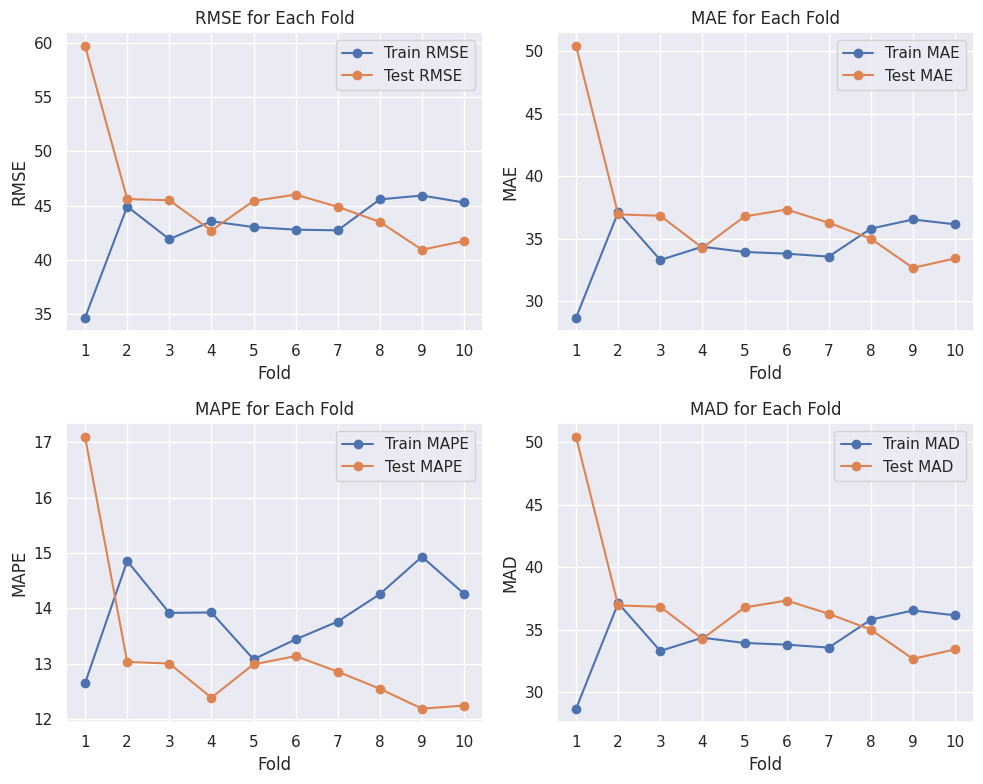

In [37]:
# Create subplots for each performance metric
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Plotting RMSE for each fold
axes[0, 0].plot(range(1, 11), train_rmse_scores, marker='o', label='Train RMSE')
axes[0, 0].plot(range(1, 11), test_rmse_scores, marker='o', label='Test RMSE')
axes[0, 0].set_title('RMSE for Each Fold')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_xticks(range(1, 11))
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plotting MAE for each fold
axes[0, 1].plot(range(1, 11), train_mae_scores, marker='o', label='Train MAE')
axes[0, 1].plot(range(1, 11), test_mae_scores, marker='o', label='Test MAE')
axes[0, 1].set_title('MAE for Each Fold')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].set_xticks(range(1, 11))
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plotting MAPE for each fold
axes[1, 0].plot(range(1, 11), train_mape_scores, marker='o', label='Train MAPE')
axes[1, 0].plot(range(1, 11), test_mape_scores, marker='o', label='Test MAPE')
axes[1, 0].set_title('MAPE for Each Fold')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('MAPE')
axes[1, 0].set_xticks(range(1, 11))
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plotting MAD for each fold
axes[1, 1].plot(range(1, 11), train_mad_scores, marker='o', label='Train MAD')
axes[1, 1].plot(range(1, 11), test_mad_scores, marker='o', label='Test MAD')
axes[1, 1].set_title('MAD for Each Fold')
axes[1, 1].set_xlabel('Fold')
axes[1, 1].set_ylabel('MAD')
axes[1, 1].set_xticks(range(1, 11))
axes[1, 1].legend()
axes[1, 1].grid(True)

# Adjust layout and display plot
plt.tight_layout()
plt.show()

**Line graphs for each performance metric (RMSE, MAE, MAPE, MAD) to visualize the performance of different models**

<ipython-input-21-3477daa5bd53>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(models, rotation=45, ha='right')


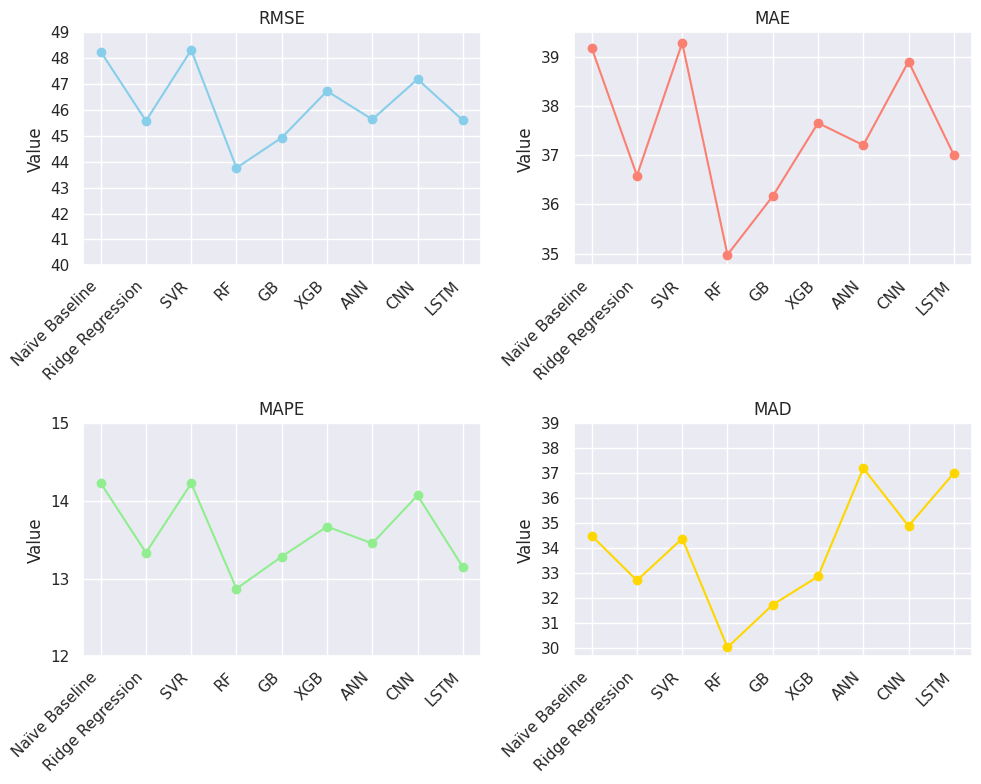

In [21]:
# Model
models = ['Naïve Baseline', 'Ridge Regression', 'SVR', 'RF', 'GB', 'XGB', 'ANN', 'CNN', 'LSTM']

# Test set performance metrics
RMSE = [48.255, 45.581, 48.318, 43.765, 44.932, 46.731, 45.636, 47.189, 45.603]
MAE = [39.180, 36.586, 39.282, 34.977, 36.167, 37.655, 37.204, 38.904, 37.006]
MAPE = [14.231, 13.334, 14.227, 12.871, 13.284, 13.671, 13.454, 14.073, 13.150]
MAD = [34.499, 32.709, 34.389, 30.032, 31.740, 32.869, 37.204, 34.892, 37.006]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# RMSE plot
axs[0, 0].plot(models, RMSE, marker='o', color='skyblue', label='RMSE')
axs[0, 0].set_title('RMSE')
axs[0, 0].set_ylabel('Value')
axs[0, 0].set_yticks(range(40, 50, 1))  # Adjust y-axis scale

# MAE plot
axs[0, 1].plot(models, MAE, marker='o', color='salmon', label='MAE')
axs[0, 1].set_title('MAE')
axs[0, 1].set_ylabel('Value')
axs[0, 1].set_yticks(range(35, 40, 1))  # Adjust y-axis scale

# MAPE plot
axs[1, 0].plot(models, MAPE, marker='o', color='lightgreen', label='MAPE')
axs[1, 0].set_title('MAPE')
axs[1, 0].set_ylabel('Value')
axs[1, 0].set_yticks(range(12, 16, 1))  # Adjust y-axis scale

# MAD plot
axs[1, 1].plot(models, MAD, marker='o', color='gold', label='MAD')
axs[1, 1].set_title('MAD')
axs[1, 1].set_ylabel('Value')
axs[1, 1].set_yticks(range(30, 40, 1))  # Adjust y-axis scale

# Rotate x-axis labels for better readability
for ax in axs.flat:
    ax.set_xticklabels(models, rotation=45, ha='right')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


**Ranking the models based on their performance metrics**

In [7]:
# Performance metrics for each model
metrics = {
    "Naïve Baseline Model": {"RMSE": 48.255, "MAE": 39.180, "MAPE": 14.231, "MAD": 34.499},
    "Ridge Regression": {"Train": {"RMSE": 38.714, "MAE": 30.705, "MAPE": 12.426, "MAD": 25.001},
                         "Test": {"RMSE": 45.581, "MAE": 36.586, "MAPE": 13.334, "MAD": 32.709}},
    "SVR": {"Train": {"RMSE": 42.298, "MAE": 33.565, "MAPE": 13.496, "MAD": 28.489},
            "Test": {"RMSE": 48.318, "MAE": 39.282, "MAPE": 14.227, "MAD": 34.389}},
    "Random Forest": {"Train": {"RMSE": 31.061, "MAE": 24.110, "MAPE": 9.726, "MAD": 19.510},
                      "Test": {"RMSE": 43.765, "MAE": 34.977, "MAPE": 12.871, "MAD": 30.032}},
    "GB": {"Train": {"RMSE": 34.334, "MAE": 27.026, "MAPE": 10.933, "MAD": 22.666},
           "Test": {"RMSE": 44.932, "MAE": 36.167, "MAPE": 13.284, "MAD": 31.740}},
    "XGB": {"Train": {"RMSE": 38.773, "MAE": 30.657, "MAPE": 12.382, "MAD": 25.786},
            "Test": {"RMSE": 46.731, "MAE": 37.655, "MAPE": 13.671, "MAD": 32.869}},
    "ANN": {"Train": {"RMSE": 39.686, "MAE": 31.220, "MAPE": 12.338, "MAD": 31.220},
            "Test": {"RMSE": 45.636, "MAE": 37.204, "MAPE": 13.454, "MAD": 37.204}},
    "LSTM": {"Train": {"RMSE": 43.043, "MAE": 34.342, "MAPE": 13.909, "MAD": 34.342},
             "Test": {"RMSE": 45.603, "MAE": 37.006, "MAPE": 13.150, "MAD": 37.006}},
    "CNN": {"Train": {"RMSE": 39.058, "MAE": 31.139, "MAPE": 12.348, "MAD": 26.296},
            "Test": {"RMSE": 47.189, "MAE": 38.904, "MAPE": 14.073, "MAD": 34.892}}
}

# Define a function to calculate ranks based on a specific metric
def calculate_ranks(metric_name, metric_type):
    if metric_type == "Train":
        values = {model: metrics[model][metric_type][metric_name] for model in metrics if metric_type in metrics[model]}
    elif metric_type == "Test":
        values = {model: metrics[model][metric_type][metric_name] for model in metrics if metric_type in metrics[model]}
    else:
        values = {model: metrics[model][metric_name] for model in metrics}
    sorted_values = sorted(values.items(), key=lambda x: x[1])
    ranks = {model: rank + 1 for rank, (model, _) in enumerate(sorted_values)}
    return ranks

# Calculate ranks for each metric using test set results
test_rmse_ranks = calculate_ranks("RMSE", "Test")
test_mae_ranks = calculate_ranks("MAE", "Test")
test_mape_ranks = calculate_ranks("MAPE", "Test")
test_mad_ranks = calculate_ranks("MAD", "Test")

# Print ranks for each metric using test set results
print("Test RMSE Ranks:", test_rmse_ranks)
print("Test MAE Ranks:", test_mae_ranks)
print("Test MAPE Ranks:", test_mape_ranks)
print("Test MAD Ranks:", test_mad_ranks)


Test RMSE Ranks: {'Random Forest': 1, 'GB': 2, 'Ridge Regression': 3, 'LSTM': 4, 'ANN': 5, 'XGB': 6, 'CNN': 7, 'SVR': 8}
Test MAE Ranks: {'Random Forest': 1, 'GB': 2, 'Ridge Regression': 3, 'LSTM': 4, 'ANN': 5, 'XGB': 6, 'CNN': 7, 'SVR': 8}
Test MAPE Ranks: {'Random Forest': 1, 'LSTM': 2, 'GB': 3, 'Ridge Regression': 4, 'ANN': 5, 'XGB': 6, 'CNN': 7, 'SVR': 8}
Test MAD Ranks: {'Random Forest': 1, 'GB': 2, 'Ridge Regression': 3, 'XGB': 4, 'SVR': 5, 'CNN': 6, 'LSTM': 7, 'ANN': 8}


**Performing Friedman test to check the significance of the comparison between different models**

In [10]:
# Define the ranks for each model across all evaluation metrics
ranks = {
    'Random Forest': [1, 1, 1, 1],  # Replace with your actual ranks
    'GB': [2, 2, 3, 2],
    'Ridge Regression': [3, 3, 4, 3],
    'LSTM': [4, 4, 2, 7],
    'ANN': [5, 5, 5, 8],
    'XGB': [6, 6, 6, 4],
    'CNN': [7, 7, 7, 6],
    'SVR': [8, 8, 8, 5]
}

# Number of models
N = len(ranks)

# Number of evaluation metrics
k = len(list(ranks.values())[0])

# Calculate the Friedman statistic
sum_ranks_squared = sum(sum(rank ** 2 for rank in model_ranks) for model_ranks in ranks.values())
chi_squared = (12 / (N * k * (k + 1))) * (sum_ranks_squared - (k * (k + 1) ** 2) / 4)

# Calculate the p-value using the chi-squared distribution
# You can use scipy.stats.chi2.sf to find the p-value
from scipy.stats import chi2
p_value = chi2.sf(chi_squared, k - 1)

print("Friedman Statistic:", chi_squared)
print("Degrees of Freedom:", k - 1)
print("p-value:", p_value)


Friedman Statistic: 59.324999999999996
Degrees of Freedom: 3
p-value: 8.192996206266687e-13


The small p-value indicates strong evidence against the null hypothesis, indicating that there are significant differences between the models' performances across the evaluation metrics. It means the performance of at least one model significantly differs from the others in at least one metric.

**Box plot to visualze the variability in each model to check the robustness**

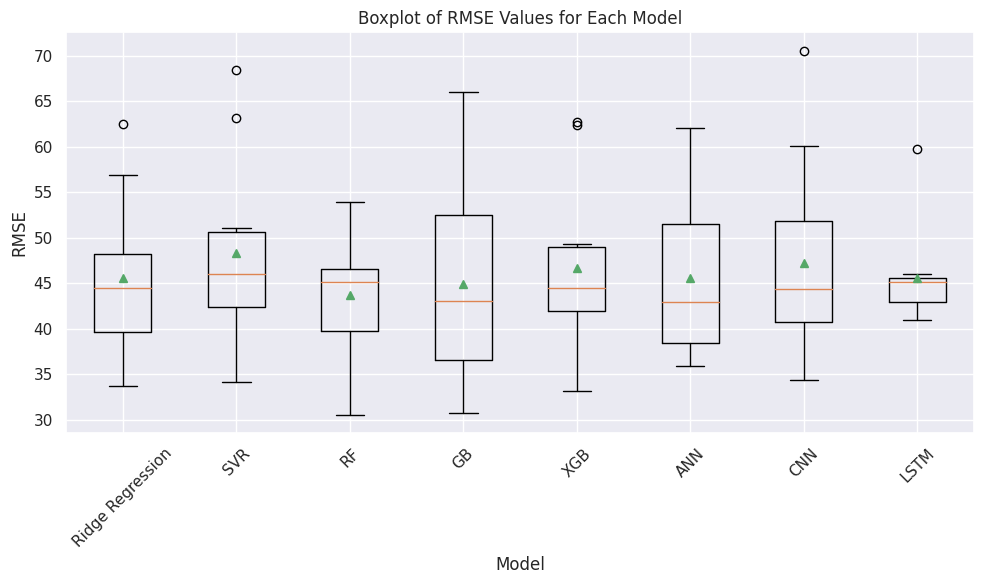

In [29]:
# RMSE values for each model
rmse_values = {
    'Ridge Regression': [62.537, 33.784, 48.844, 38.057, 39.158, 41.296, 56.918, 46.201, 43.713, 45.293],
    'SVR': [68.390, 34.169, 51.129, 39.973, 43.497, 42.715, 63.171, 42.289, 48.568, 49.270],
    'RF': [46.881, 43.612, 45.361, 35.842, 30.597, 45.637, 53.918, 52.308, 38.501, 44.988],
    'GB': [65.982, 34.996, 45.484, 35.423, 30.715, 48.089, 53.972, 53.929, 40.553, 40.177],
    'XGB': [62.698, 33.203, 49.264, 38.395, 41.804, 42.535, 62.399, 42.644, 46.290, 48.074],
    'ANN': [52.269, 36.992, 55.770, 35.888, 37.633, 40.903, 62.001, 41.966, 49.077, 43.862],
    'CNN': [70.552, 35.614, 46.363, 41.926, 34.432, 40.421, 53.726, 43.310, 45.517, 60.027],
    'LSTM': [59.691, 45.606, 45.493, 42.708, 45.431, 46.015, 44.890, 43.503, 40.946, 41.742]
}

# Convert dictionary of RMSE values to a list of lists
rmse_data = list(rmse_values.values())

# Model names
model_names = list(rmse_values.keys())

# Create boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(rmse_data, labels=model_names, showmeans=True)
plt.title('Boxplot of RMSE Values for Each Model')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

**Calculating the critical difference (CD) value to understand the performance differences between models**

In [17]:
# understanding of the performance differences between models
# Dictionary of test ranks
test_ranks = {
    'Random Forest': 1,
    'GB': 2,
    'Ridge Regression': 3,
    'LSTM': 4,
    'ANN': 5,
    'XGB': 6,
    'CNN': 7,
    'SVR': 8
}

# Convert dictionary values to a list of ranks
ranks = list(test_ranks.values())

# Number of models
k = len(ranks)

# Number of datasets or folds
n = 10  # as in time series CV n=10

# Calculate average rank
avg_rank = np.mean(ranks)

# Compute the critical difference (CD) value
alpha = 0.05  # Significance level
q_alpha = 2.086  # Value from the Studentized range distribution for alpha=0.05 and df=8
CD = q_alpha * np.sqrt(k * (k + 1) / (6 * n))

# Compare the difference in average ranks between each pair of models with the CD value
for model1, rank1 in test_ranks.items():
    for model2, rank2 in test_ranks.items():
        if model1 != model2:
            diff = np.abs(rank1 - rank2)
            if diff > CD:
                print(f"{model1} and {model2} are significantly different.")


Random Forest and LSTM are significantly different.
Random Forest and ANN are significantly different.
Random Forest and XGB are significantly different.
Random Forest and CNN are significantly different.
Random Forest and SVR are significantly different.
GB and ANN are significantly different.
GB and XGB are significantly different.
GB and CNN are significantly different.
GB and SVR are significantly different.
Ridge Regression and XGB are significantly different.
Ridge Regression and CNN are significantly different.
Ridge Regression and SVR are significantly different.
LSTM and Random Forest are significantly different.
LSTM and CNN are significantly different.
LSTM and SVR are significantly different.
ANN and Random Forest are significantly different.
ANN and GB are significantly different.
ANN and SVR are significantly different.
XGB and Random Forest are significantly different.
XGB and GB are significantly different.
XGB and Ridge Regression are significantly different.
CNN and R

**Performing residual analysis for the top model: Random Forest**

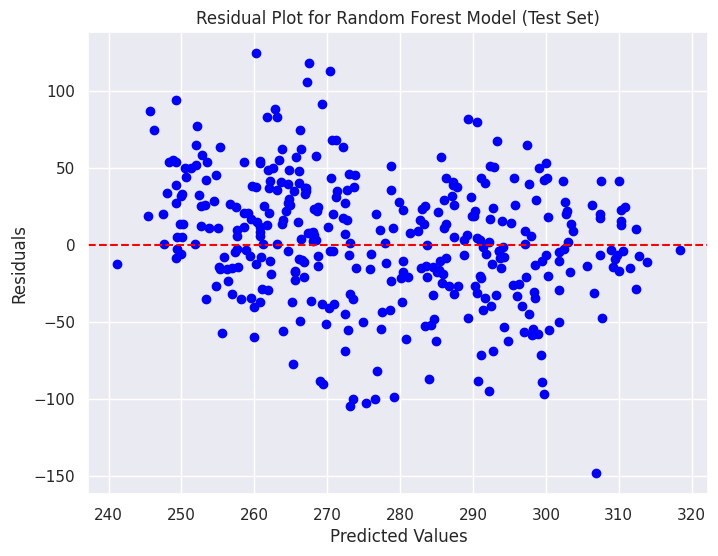

Test RMSE: 41.50669941804453


In [16]:
# Predict on the test set
y_test_pred = rf_model.predict(X_test_subset)

# Calculate residuals
test_residuals = y_test - y_test_pred

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pred, test_residuals, color='blue')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for Random Forest Model (Test Set)')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Calculate RMSE on the test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Test RMSE:", test_rmse)


The residuals are mostly randomly distributed around the zero line without showing any pattern, indicating that the model's predictions are mostly unbiased.

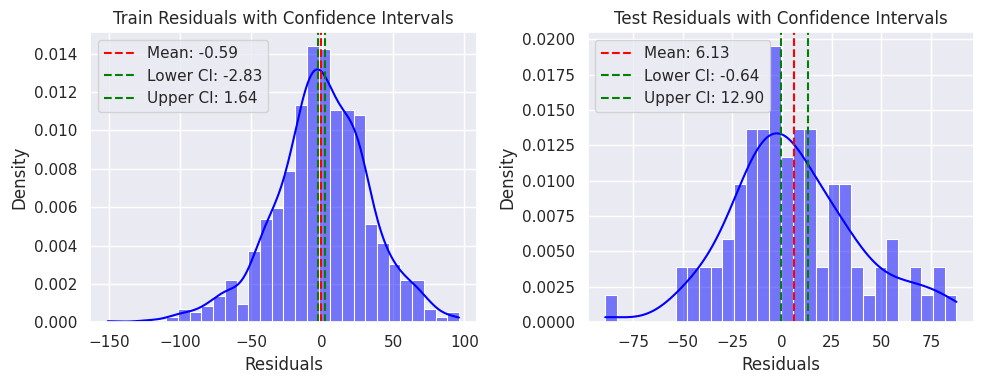

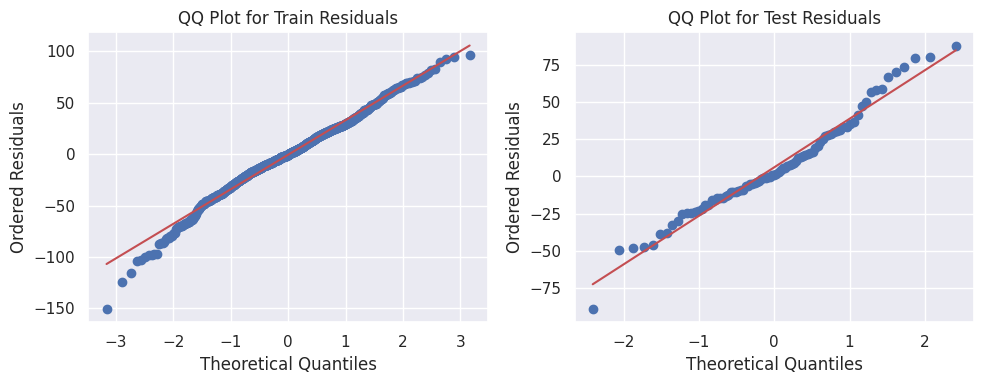

In [29]:
from scipy.stats import probplot
# Calculate residuals
train_residuals = y_train_fold - rf_model.predict(X_train_fold)
test_residuals = y_test_fold - rf_model.predict(X_test_fold)

# Confidence intervals for train residuals
train_mean = np.mean(train_residuals)
train_std = np.std(train_residuals)
train_ci = 1.96 * (train_std / np.sqrt(len(train_residuals)))  # 95% confidence interval

# Confidence intervals for test residuals
test_mean = np.mean(test_residuals)
test_std = np.std(test_residuals)
test_ci = 1.96 * (test_std / np.sqrt(len(test_residuals)))  # 95% confidence interval

# Plot train and test residuals with confidence intervals side by side
plt.figure(figsize=(10, 4))

# Train residuals with confidence intervals
plt.subplot(1, 2, 1)
sns.histplot(train_residuals, kde=True, stat='density', color='blue', bins=30)
plt.axvline(train_mean, color='red', linestyle='--', label=f'Mean: {train_mean:.2f}')
plt.axvline(train_mean - train_ci, color='green', linestyle='--', label=f'Lower CI: {train_mean - train_ci:.2f}')
plt.axvline(train_mean + train_ci, color='green', linestyle='--', label=f'Upper CI: {train_mean + train_ci:.2f}')
plt.title('Train Residuals with Confidence Intervals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()

# Test residuals with confidence intervals
plt.subplot(1, 2, 2)
sns.histplot(test_residuals, kde=True, stat='density', color='blue', bins=30)
plt.axvline(test_mean, color='red', linestyle='--', label=f'Mean: {test_mean:.2f}')
plt.axvline(test_mean - test_ci, color='green', linestyle='--', label=f'Lower CI: {test_mean - test_ci:.2f}')
plt.axvline(test_mean + test_ci, color='green', linestyle='--', label=f'Upper CI: {test_mean + test_ci:.2f}')
plt.title('Test Residuals with Confidence Intervals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

# QQ plots side by side
plt.figure(figsize=(10, 4))

# QQ plot for train residuals
plt.subplot(1, 2, 1)
probplot(train_residuals, dist="norm", plot=plt)
plt.title('QQ Plot for Train Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Residuals')

# QQ plot for test residuals
plt.subplot(1, 2, 2)
probplot(test_residuals, dist="norm", plot=plt)
plt.title('QQ Plot for Test Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Residuals')

plt.tight_layout()
plt.show()


 We are 95% confident that the true mean of the test residuals lies within the range from approximately -0.64 to 12.09. The mean value of 6.13 indicates that, on average, the residuals for the test set are higher than those for the train set, suggesting some variability while making prediction on unseen data.

 QQ plot compares the quantiles of the residuals to the quantiles of a theoretical normal distribution. Here in the QQ plot, some points are deviated from the straight line in the tails of the distribution, which suggests departure of residuals from normality and indicate the presence of outliers or heavy-tailed distributions.


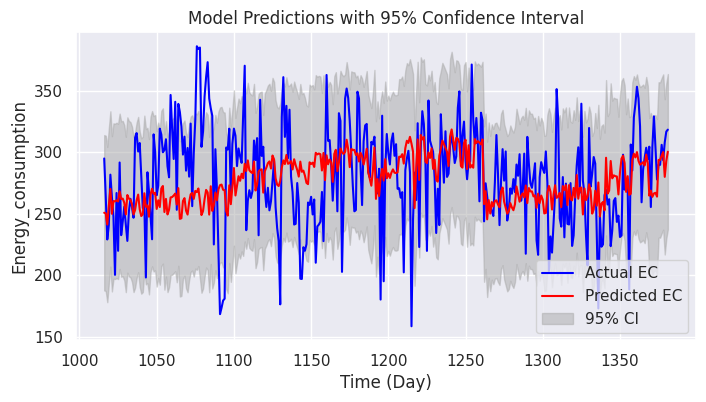

In [35]:
# Plot EC vs time with model predictions and confidence interval
plt.figure(figsize=(8, 4))

# Plot the actual EC values
plt.plot(X_test.index, y_test, color='blue', label='Actual EC')

# Plot the model predictions
plt.plot(X_test.index, y_test_pred, color='red', label='Predicted EC')

# Calculate the upper and lower bounds of the confidence interval
ci_upper = y_test_pred + 1.96 * np.std(test_residuals)
ci_lower = y_test_pred - 1.96 * np.std(test_residuals)

# Fill the area between the upper and lower bounds with a color to represent the confidence interval
plt.fill_between(X_test.index, ci_lower, ci_upper, color='darkgray', alpha=0.5, label='95% CI')

# Add labels and title
plt.xlabel('Time (Day)')
plt.ylabel('Energy_consumption')
plt.title('Model Predictions with 95% Confidence Interval')
plt.legend()
plt.show()


CI covers all the data points from the unseen test dataset to validate the model predictions by the RF model.